In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import joblib
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

from keras.layers.core import Dense, Dropout, Activation
import keras.callbacks as callbacks
from keras.utils import np_utils

import Models
from AuxiliarFunctions import *

In [2]:
config_file_path = 'data/config.csv'
df_config = pd.read_csv(config_file_path)
train_id = 0

In [3]:
dev_social = pd.read_csv(os.path.join(df_config['processed_file_folder'][train_id],'dev_social.csv'))
dev_personal = pd.read_csv(os.path.join(df_config['processed_file_folder'][train_id],'dev_personal.csv'))
dev_clinical = pd.read_csv(os.path.join(df_config['processed_file_folder'][train_id],'dev_clinical.csv'))
dev_pos_test = pd.read_csv(os.path.join(df_config['processed_file_folder'][train_id],'dev_pos_test.csv'))
dev_target = pd.read_csv(os.path.join(df_config['processed_file_folder'][train_id],'dev_target.csv'))

# Análise dos dados de Pós-Test

In [4]:
data = dev_pos_test

# primeiro: encher os dados faltantes
data.fillna(0.0, inplace=True)

for exam in data:
    print('Analisando %s'%(exam))

    print('Sensitivity: ',Models.sensitivity_score(dev_target[data[exam]!=0],data[data[exam]!=0][exam]))
    print('Specificity: ',Models.specificity_score(dev_target[data[exam]!=0],data[data[exam]!=0][exam]))
    print('Accuracy: ',Models.acc_score(dev_target[data[exam]!=0],data[data[exam]!=0][exam]))
    print('SP index: ',Models.sp_index(dev_target[data[exam]!=0],data[data[exam]!=0][exam]))

Analisando citometria
Sensitivity:  0.7
Specificity:  0.8
Accuracy:  0.75
SP index:  0.5612486080160912
Analisando proteina
Sensitivity:  1.0
Specificity:  0.3076923076923077
Accuracy:  0.7857142857142857
SP index:  0.3626885898395729
Analisando ada
Sensitivity:  0.8571428571428571
Specificity:  0.5
Accuracy:  0.75
SP index:  0.44422927655184163
Analisando dif cit
Sensitivity:  0.8387096774193549
Specificity:  0.23076923076923078
Accuracy:  0.6590909090909091
SP index:  0.2352539946930643


In [5]:
data = dev_pos_test

# primeiro: encher os dados faltantes
data.fillna(0.0, inplace=True)

n_folds =  df_config['cv_folds'][train_id]
cv_path = df_config['cv_path'][train_id]

figure_of_merit_names = ['sens', 'spec', 'acc', 'sp']

df_buffer = None
df_train = pd.DataFrame(data=np.zeros([df_config['cv_folds'][train_id],
                                       len(figure_of_merit_names)]), columns=figure_of_merit_names)

for exam in data:
    df_train = pd.DataFrame(data=np.zeros([df_config['cv_folds'][train_id],
                                       len(figure_of_merit_names)]), columns=figure_of_merit_names)
    print('Analisando %s'%(exam))
    for ifold in range(n_folds):
        print('Analysing %i fold of %i folds'%(ifold+1, n_folds))
        cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                           df_config['cv_alg'][train_id],
                                                           ifold, n_folds)
        with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
            [trn_idx,val_idx] = pickle.load(file_handler)
        
        trn_data = data.iloc[trn_idx,:]
        trn_trgt = dev_target.iloc[trn_idx]
        
        df_train.loc[ifold,'exam'] = exam
        
        for figure_of_merit in figure_of_merit_names:
            if figure_of_merit == 'sens':
                df_train.loc[ifold, figure_of_merit] = Models.sensitivity_score(trn_trgt[trn_data[exam]!=0],
                                                                                trn_data[trn_data[exam]!=0][exam])
            if figure_of_merit == 'spec':
                df_train.loc[ifold, figure_of_merit] = Models.specificity_score(trn_trgt[trn_data[exam]!=0],
                                                                                trn_data[trn_data[exam]!=0][exam])
            if figure_of_merit == 'acc':
                df_train.loc[ifold, figure_of_merit] = Models.acc_score(trn_trgt[trn_data[exam]!=0],
                                                                        trn_data[trn_data[exam]!=0][exam])
            if figure_of_merit == 'sp':
                df_train.loc[ifold, figure_of_merit] = Models.sp_index(trn_trgt[trn_data[exam]!=0],
                                                                       trn_data[trn_data[exam]!=0][exam])
    if df_buffer is None:
        df_buffer = df_train
    else:
        df_buffer = pd.concat([df_buffer, df_train], axis=0)


Analisando citometria
Analysing 1 fold of 5 folds
Analysing 2 fold of 5 folds
Analysing 3 fold of 5 folds
Analysing 4 fold of 5 folds
Analysing 5 fold of 5 folds
Analisando proteina
Analysing 1 fold of 5 folds
Analysing 2 fold of 5 folds
Analysing 3 fold of 5 folds
Analysing 4 fold of 5 folds
Analysing 5 fold of 5 folds
Analisando ada
Analysing 1 fold of 5 folds
Analysing 2 fold of 5 folds
Analysing 3 fold of 5 folds
Analysing 4 fold of 5 folds
Analysing 5 fold of 5 folds
Analisando dif cit
Analysing 1 fold of 5 folds
Analysing 2 fold of 5 folds
Analysing 3 fold of 5 folds
Analysing 4 fold of 5 folds
Analysing 5 fold of 5 folds


In [6]:
df_buffer[df_buffer['exam'] == 'dif cit'].loc[:, df_buffer.columns != 'exam'].mean()

sens    0.837923
spec    0.229091
acc     0.658412
sp      0.232736
dtype: float64

In [7]:
df_buffer[df_buffer['exam'] == 'dif cit'].loc[:, df_buffer.columns != 'exam'].std()

sens    0.032975
spec    0.081159
acc     0.028187
sp      0.060572
dtype: float64

In [8]:


for ifold in range(n_folds):
    print('Analysing %i fold of %i folds\n\n'%(ifold+1, n_folds))
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
        
    trn_data = data.iloc[trn_idx,:]
    trn_trgt = dev_target.iloc[trn_idx]
            
    for exam in trn_data:
        print('Analisando %s'%(exam))
        
        df_train.loc[ifold,'exam'] = exam
        for figure_of_merit in figure_of_merit_names[1::]:
            if figure_of_merit == 'sens':
                df_train.loc[ifold,figure_of_merit] = Models.sensitivity_score(trn_trgt[trn_data[exam]!=0],
                                                                                trn_data[trn_data[exam]!=0][exam])

        print('Sensitivity: ',Models.sensitivity_score(trn_trgt[trn_data[exam]!=0],trn_data[trn_data[exam]!=0][exam]))
    if df_buffer is None:
        df_buffer = df_train
    else:
        df_buffer = pd.concat([df_buffer, df_train], axis=0)

Analysing 1 fold of 5 folds


Analisando citometria
Sensitivity:  0.6666666666666666
Analisando proteina
Sensitivity:  1.0
Analisando ada
Sensitivity:  0.8461538461538461
Analisando dif cit
Sensitivity:  0.8846153846153846
Analysing 2 fold of 5 folds


Analisando citometria
Sensitivity:  0.7
Analisando proteina
Sensitivity:  1.0
Analisando ada
Sensitivity:  0.8181818181818182
Analisando dif cit
Sensitivity:  0.84
Analysing 3 fold of 5 folds


Analisando citometria
Sensitivity:  0.7
Analisando proteina
Sensitivity:  1.0
Analisando ada
Sensitivity:  0.7777777777777778
Analisando dif cit
Sensitivity:  0.7916666666666666
Analysing 4 fold of 5 folds


Analisando citometria
Sensitivity:  0.5714285714285714
Analisando proteina
Sensitivity:  1.0
Analisando ada
Sensitivity:  0.9
Analisando dif cit
Sensitivity:  0.84
Analysing 5 fold of 5 folds


Analisando citometria
Sensitivity:  1.0
Analisando proteina
Sensitivity:  1.0
Analisando ada
Sensitivity:  0.9230769230769231
Analisando dif cit
Sensit

In [9]:
df_train

sens      spec       acc        sp     exam
0  0.884615  0.272727  0.702703  0.284232  dif cit
1  0.840000  0.100000  0.628571  0.136219  dif cit
2  0.791667  0.300000  0.647059  0.266006  dif cit
3  0.840000  0.272727  0.666667  0.266295  dif cit
4  0.833333  0.200000  0.647059  0.210928  dif cit

# Curvas de Treinamento




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Analysing 1 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_personal.pkl


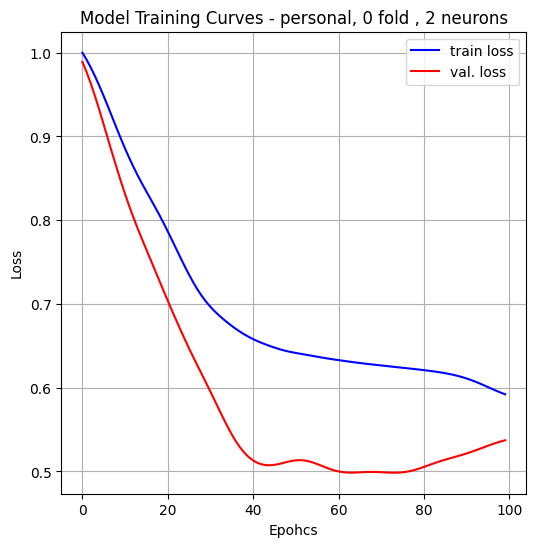

Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_social.pkl


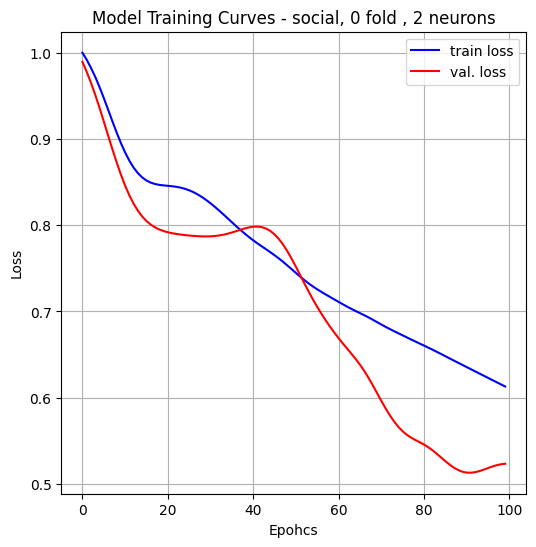

Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_3_neuron_0_init_model_clinical.pkl


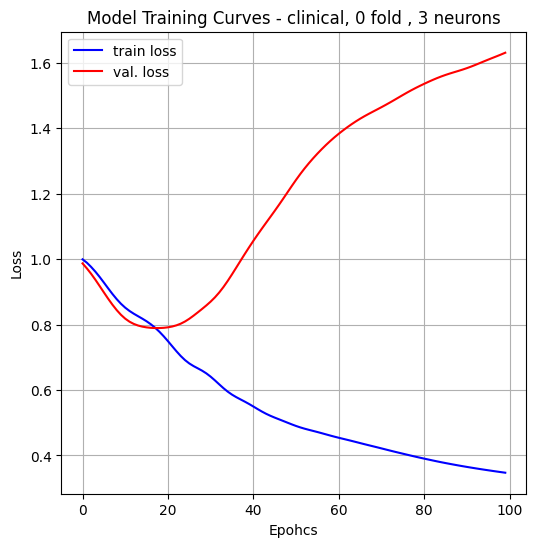

Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_pos_test.pkl


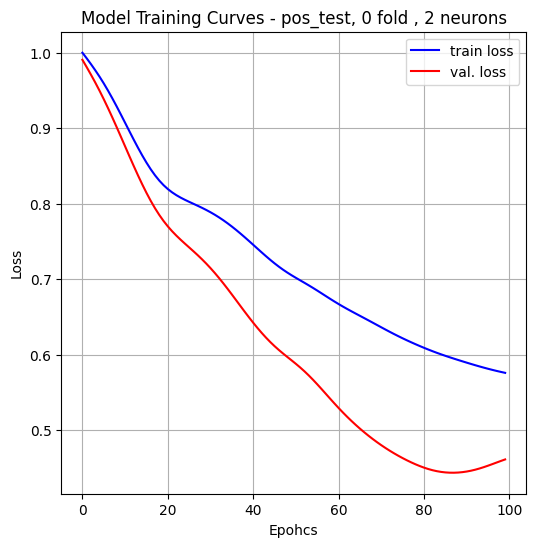

Processing PeSo
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_PeSo.pkl


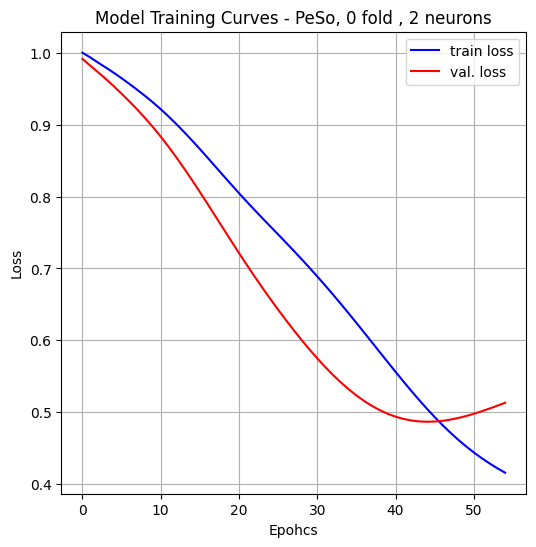

Processing PeSoCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_PeSoCli.pkl


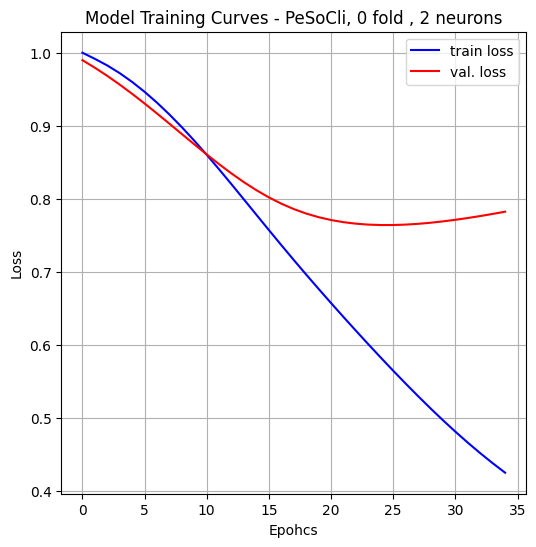

Processing PeCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_PeCli.pkl


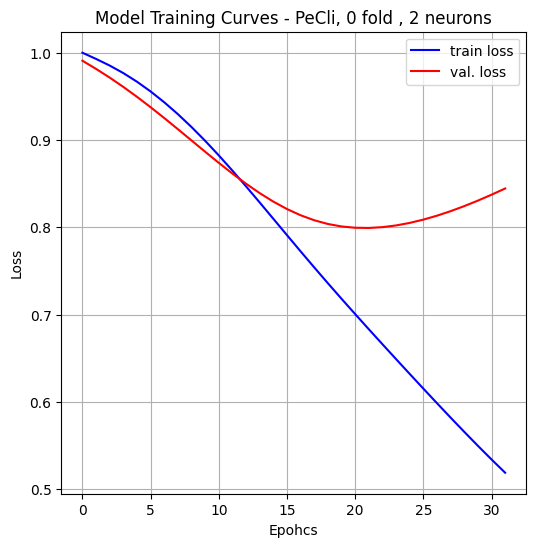

Processing CliPos
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_CliPos.pkl


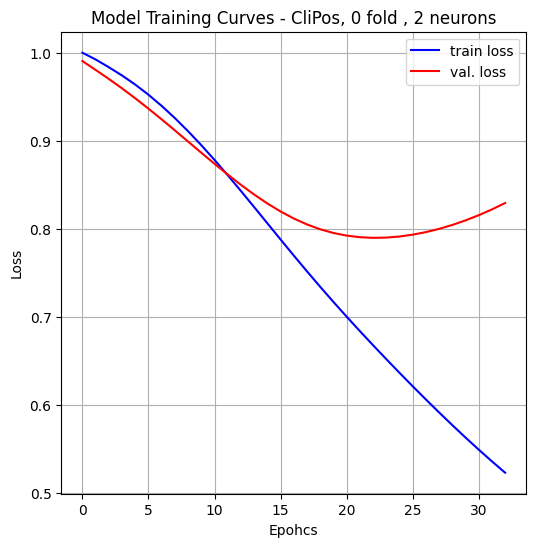

Processing PeSoCliPos_par
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl


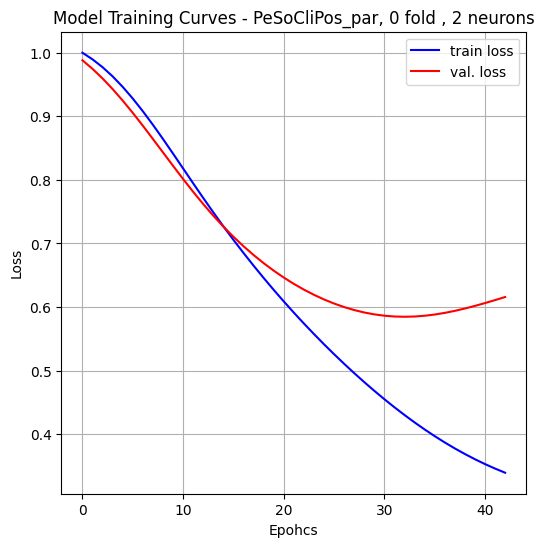

Analysing 2 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_personal.pkl


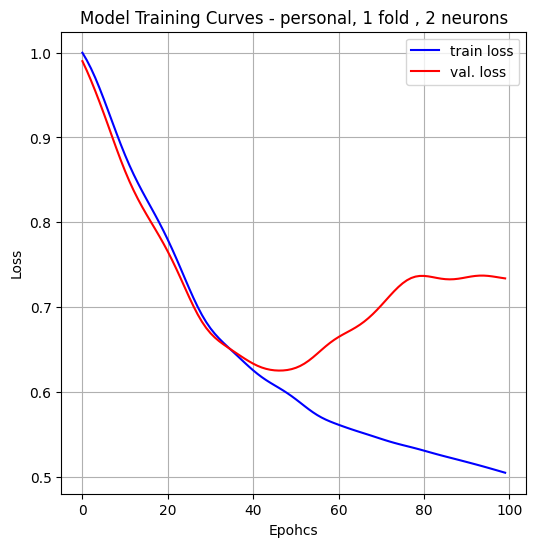

Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_social.pkl


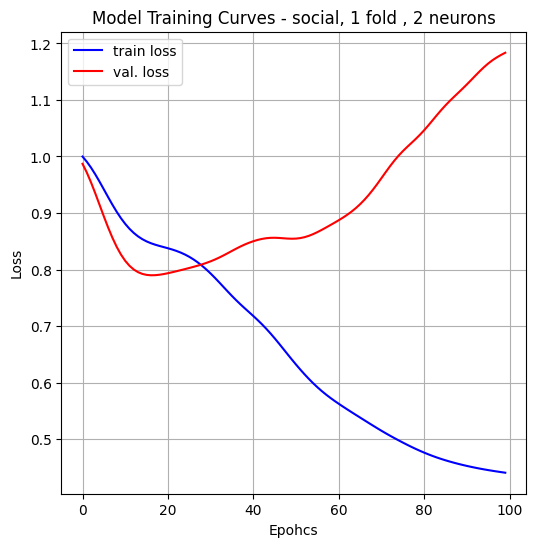

Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_3_neuron_0_init_model_clinical.pkl


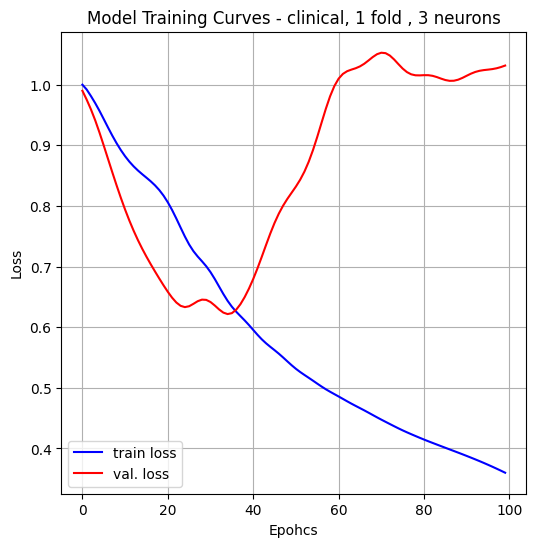

Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_pos_test.pkl


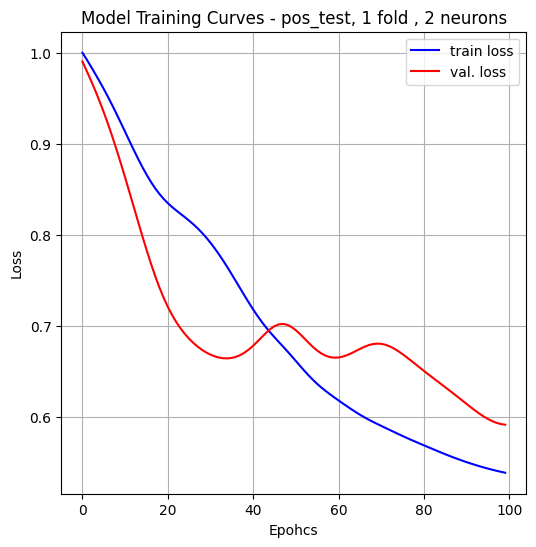

Processing PeSo
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_PeSo.pkl


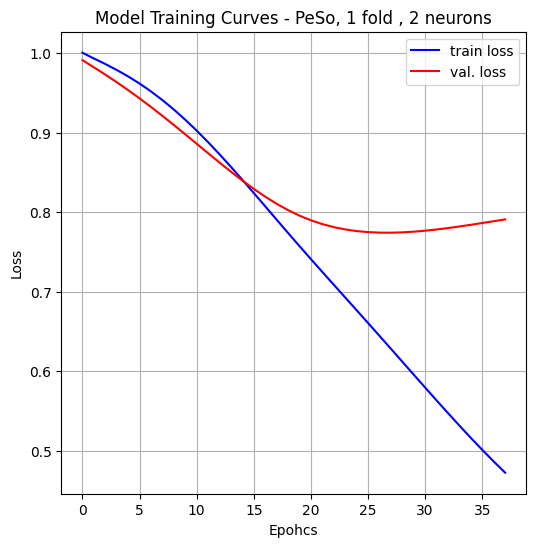

Processing PeSoCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_PeSoCli.pkl


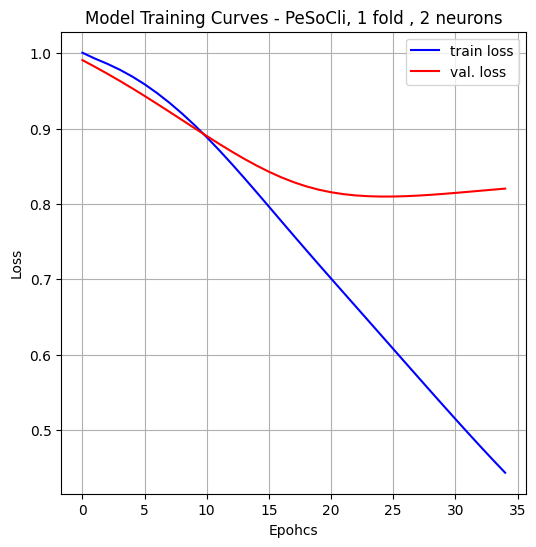

Processing PeCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_PeCli.pkl


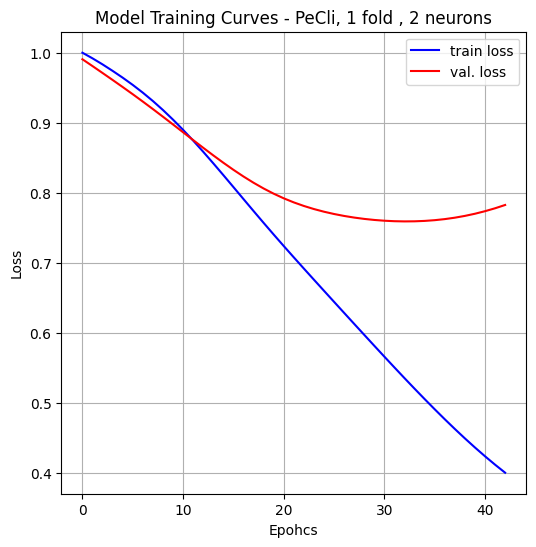

Processing CliPos
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_CliPos.pkl


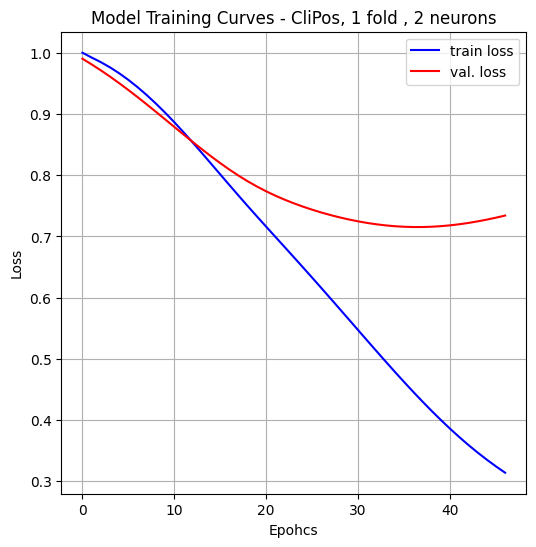

Processing PeSoCliPos_par
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl


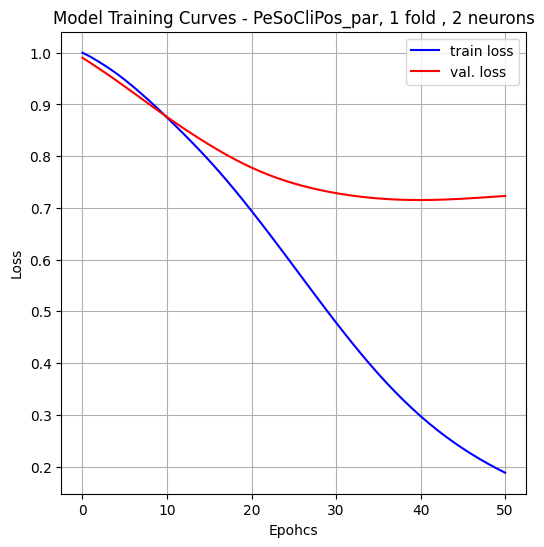

Analysing 3 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_personal.pkl


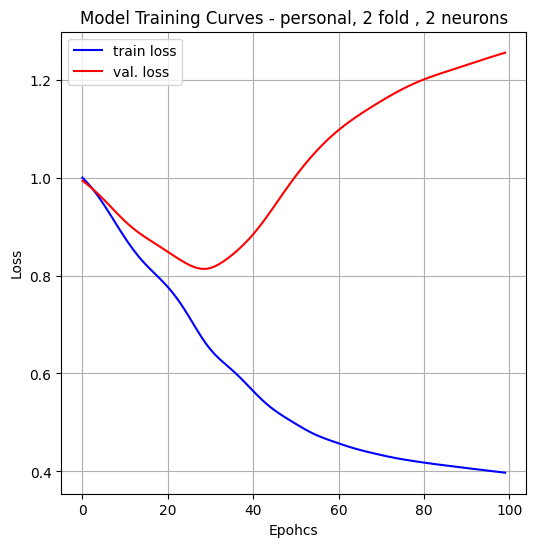

Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_social.pkl


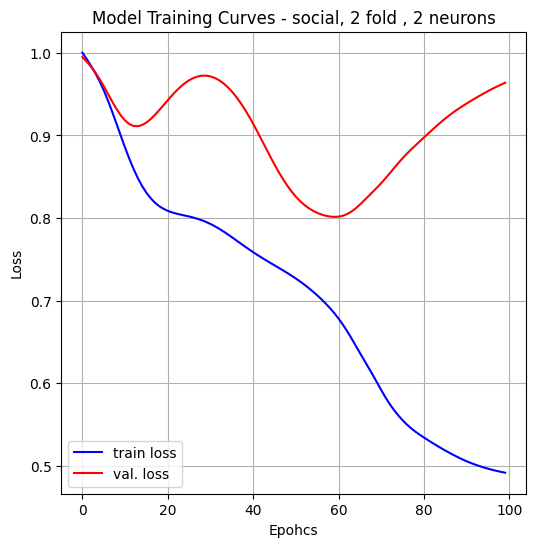

Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_3_neuron_0_init_model_clinical.pkl


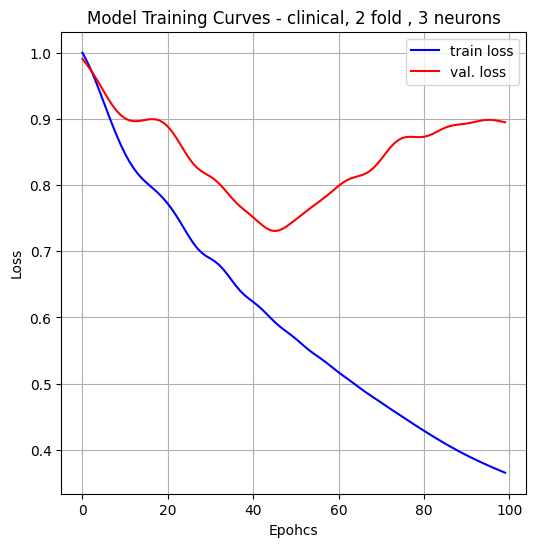

Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_pos_test.pkl


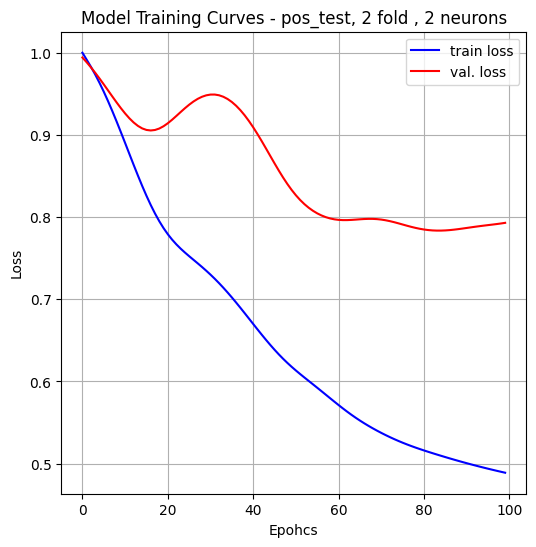

Processing PeSo
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_PeSo.pkl


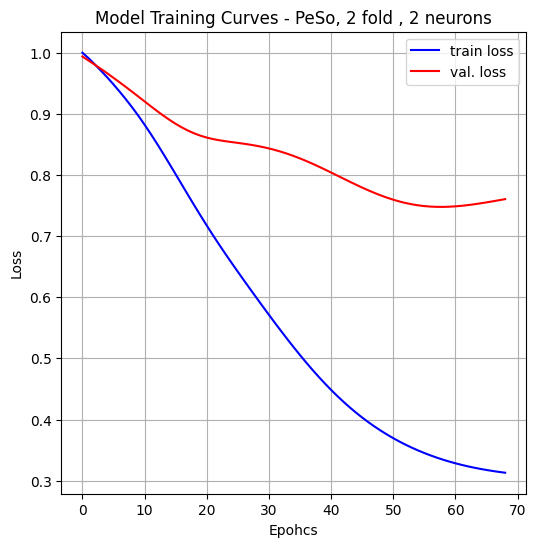

Processing PeSoCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_PeSoCli.pkl


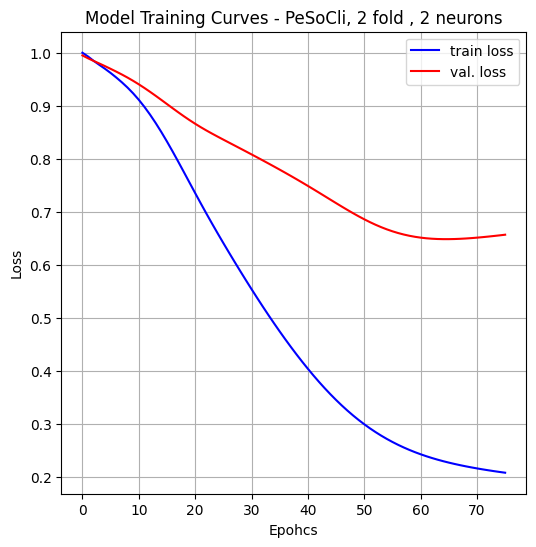

Processing PeCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_PeCli.pkl


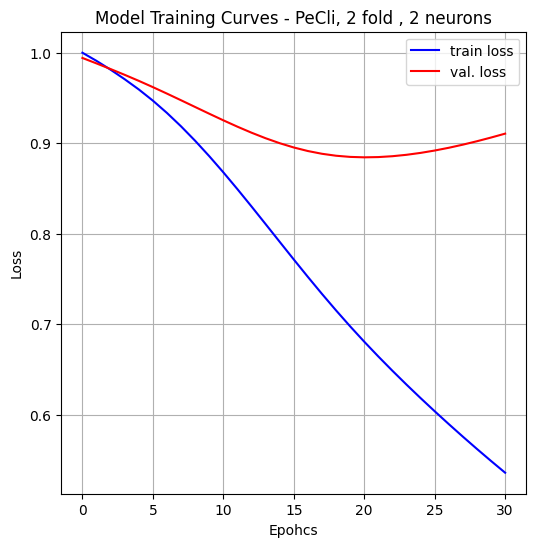

Processing CliPos
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_CliPos.pkl


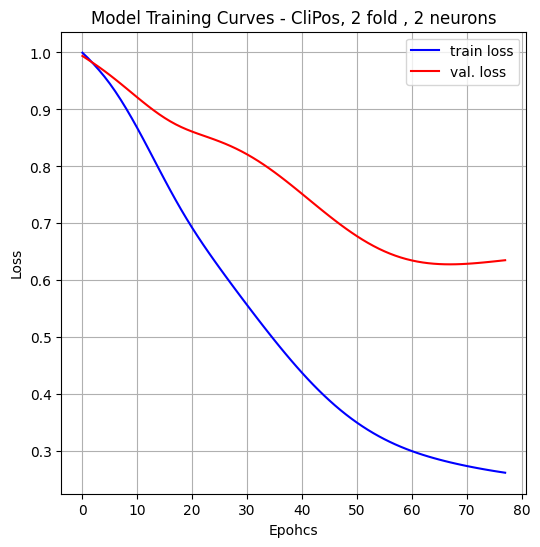

Processing PeSoCliPos_par
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl


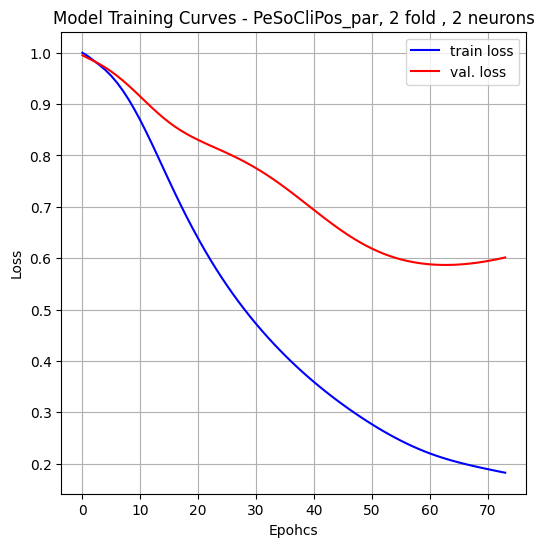

Analysing 4 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_personal.pkl


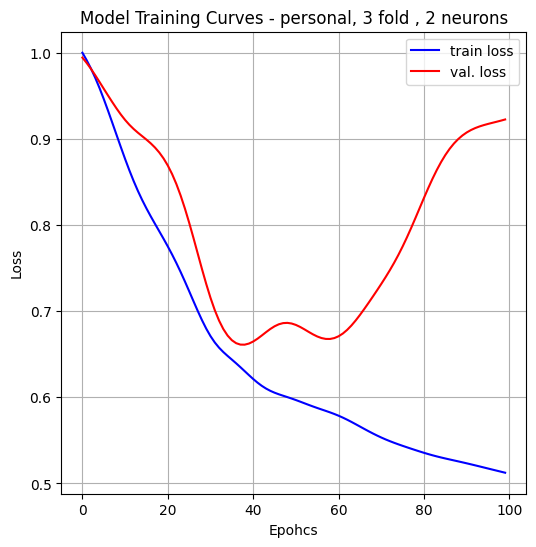

Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_social.pkl


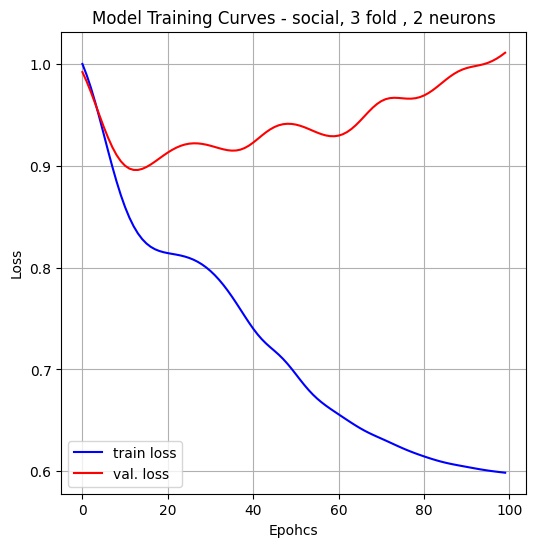

Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_3_neuron_0_init_model_clinical.pkl


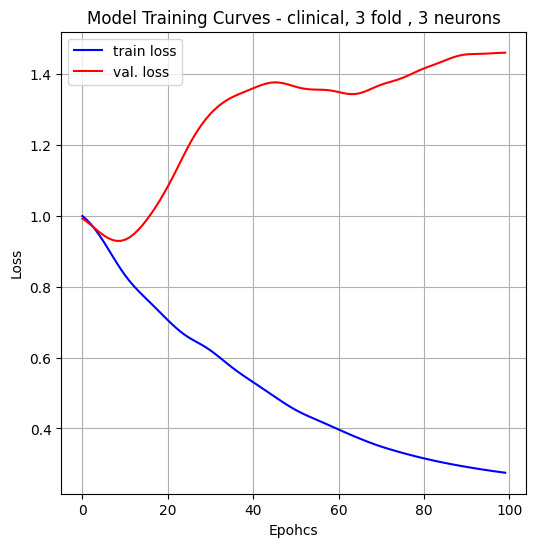

Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_pos_test.pkl


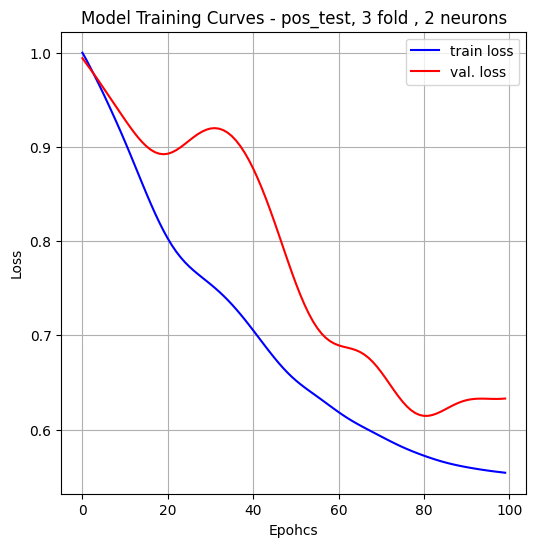

Processing PeSo
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_PeSo.pkl


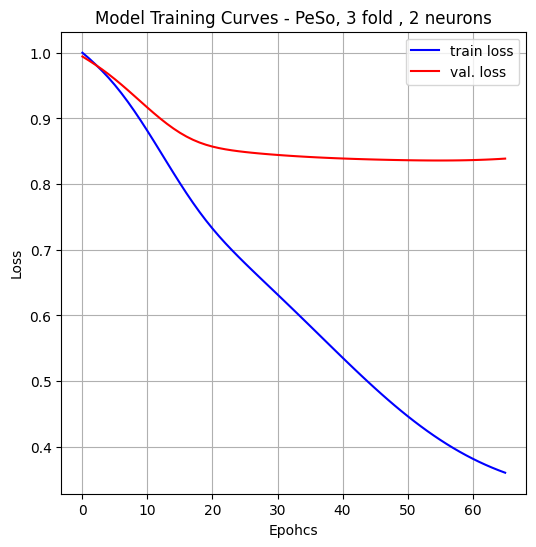

Processing PeSoCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_PeSoCli.pkl


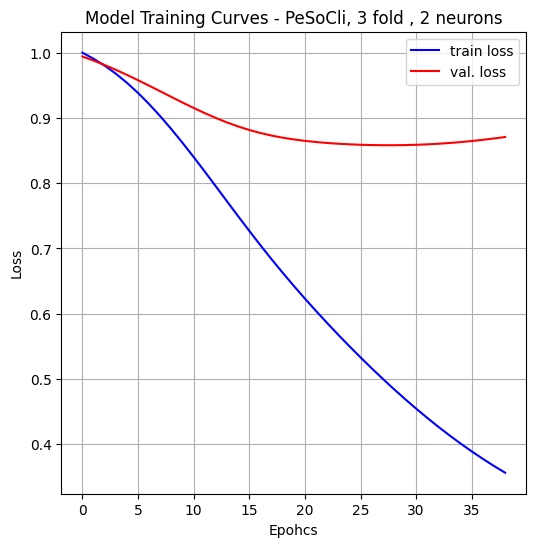

Processing PeCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_PeCli.pkl


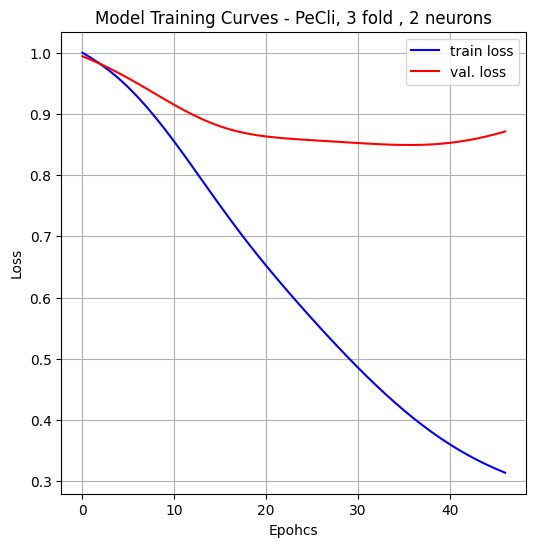

Processing CliPos
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_CliPos.pkl


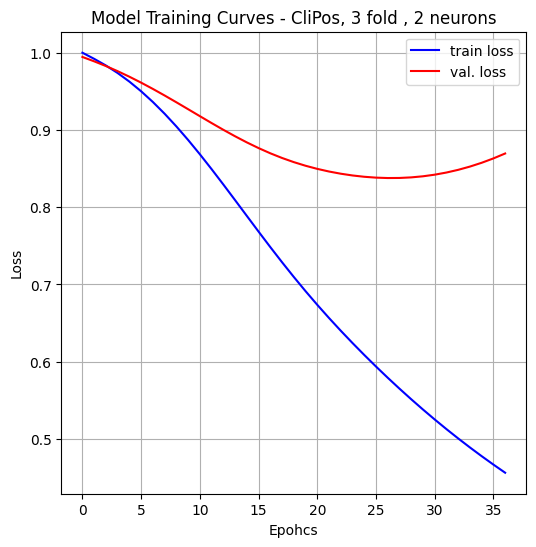

Processing PeSoCliPos_par
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl


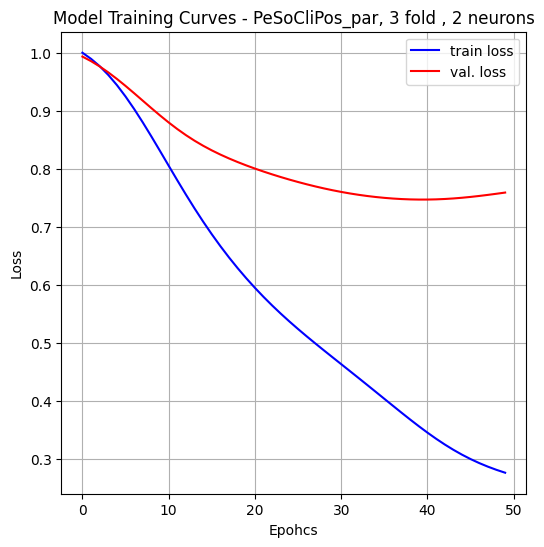

Analysing 5 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_personal.pkl


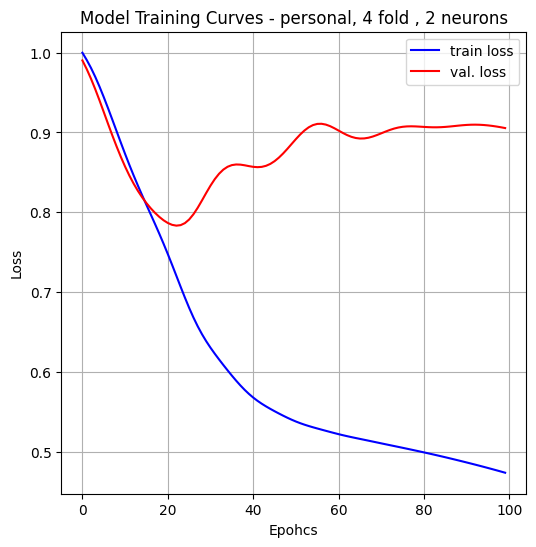

Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_social.pkl


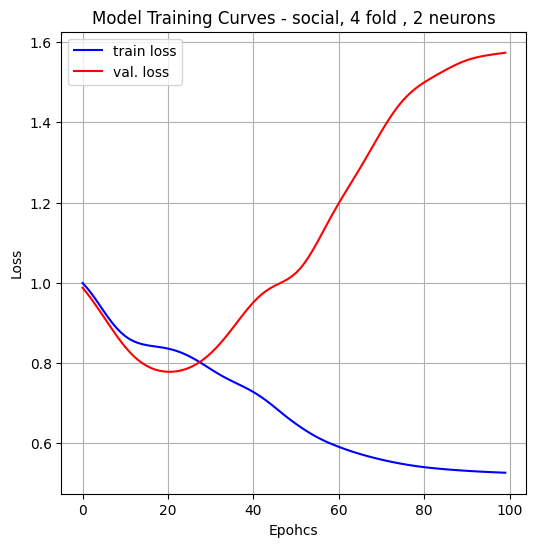

Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_3_neuron_0_init_model_clinical.pkl


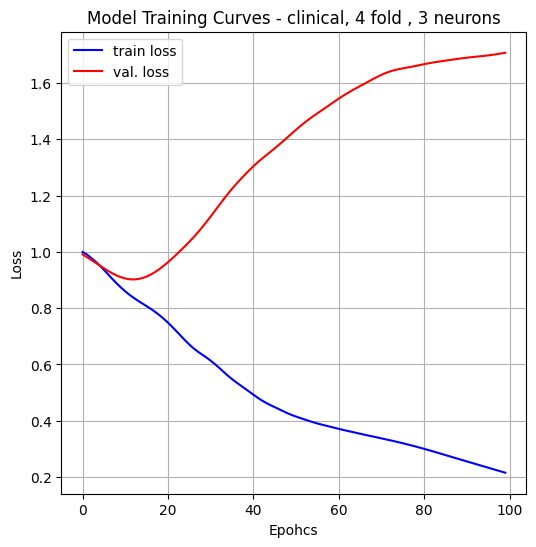

Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_pos_test.pkl


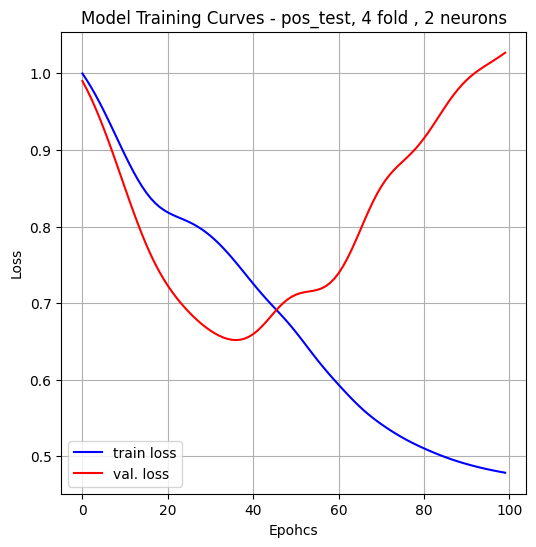

Processing PeSo
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSo.pkl


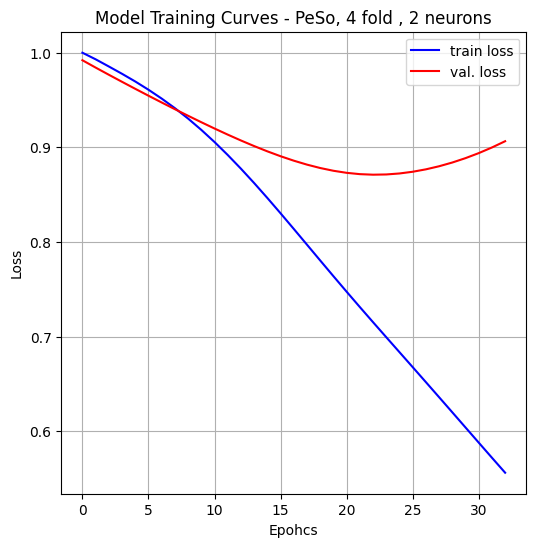

Processing PeSoCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCli.pkl


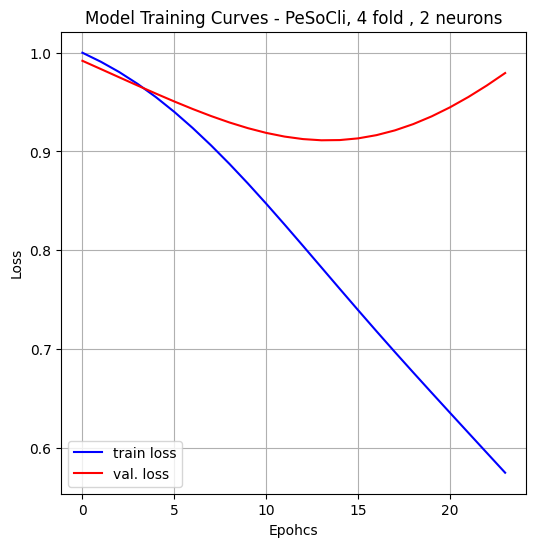

Processing PeCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeCli.pkl


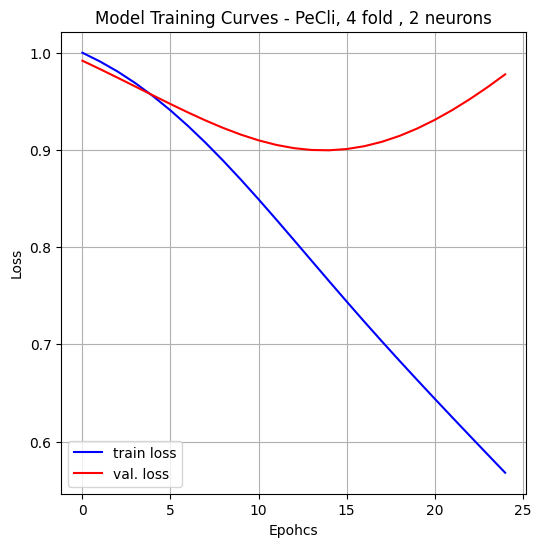

Processing CliPos
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_CliPos.pkl


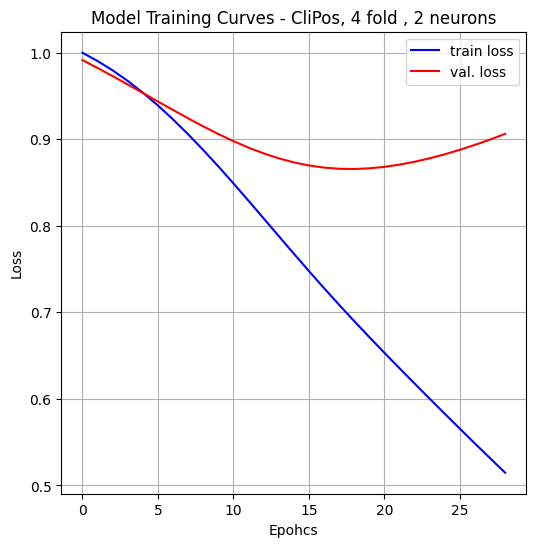

Processing PeSoCliPos_par
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl


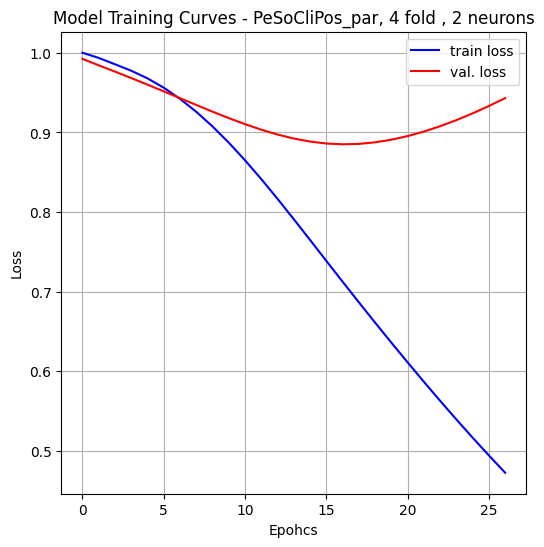

In [10]:
import matplotlib.pyplot as plt

model_type = 'MLPNeuralNetwork'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]

n_folds = df_config['cv_folds'][train_id]
hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))

datasets_name = ['personal', 'social', 'clinical', 'pos_test', 'PeSo', 'PeSoCli', 'PeCli', 'CliPos', 'PeSoCliPos_par']

# numero de neuronios de cada modelo que vai realizar a fusão
previous_neuron = [2, 2, 3, 2, 2, 2, 2, 2, 2]
previous_init = [0, 0, 0, 0, 0, 0, 0, 0, 0]
df_fusion = pd.DataFrame()

print(get_train_description(df_config, train_id))

for ifold in range(n_folds):
    #if ifold != 0: # para desenvolvimento
    #    break
    print('Analysing %i fold of %i folds\n\n'%(ifold+1, n_folds))
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
        
    # agora eu tenho que fazer a saída de cada um dos modelos base e gerar um banco novo
    for idataset, dataset_name in enumerate(datasets_name):  
        print('Processing %s'%(dataset_name))
       
        model_path = df_config['model_path'][train_id]
        
        #carregar o modelo certo
        model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                     model_type,ifold, 
                                                                     previous_neuron[idataset], 
                                                                     previous_init[idataset],
                                                                     datasets_name[idataset])
        
        if os.path.exists(os.path.join(model_path, model_name)):
            print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            
            model = Models.MLPModel(n_hidden_neurons=previous_neuron[idataset],verbose=2)
            model.load(os.path.join(model_path, model_name))
            
            fig, ax = plt.subplots(figsize=(6, 6))
            
            ax.plot(model.trn_history.epoch,
                    model.trn_history.history['mse'], 
                    color='b', label='train loss')
            ax.plot(model.trn_history.epoch,
                    model.trn_history.history['val_mse'], 
                    color='r', label='val. loss')
            ax.grid()
            ax.legend(loc='best')
            ax.set_title('Model Training Curves - %s, %i fold , %i neurons'%(datasets_name[idataset],
                                                                             ifold, previous_neuron[idataset]))
            ax.set_xlabel('Epohcs')
            ax.set_ylabel('Loss')
            plt.show()
            
            
                

# Análise Básica

In [11]:
ineuron = 2
iinit = 0
dataset_name = 'personal'#'personal', 'social', 'clinical', 'pos_test', 'PeSo'
figure_of_merit_names = ['sens', 'spec', 'acc', 'sp']

model_type = 'MLPNeuralNetwork'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]

model_path = df_config['model_path'][train_id]

df_train = pd.DataFrame(data=np.zeros([df_config['cv_folds'][train_id],len(figure_of_merit_names)]), columns=figure_of_merit_names)
df_val = pd.DataFrame(np.zeros([df_config['cv_folds'][train_id],len(figure_of_merit_names)]),columns=figure_of_merit_names)

for ifold in range(df_config['cv_folds'][train_id]):
    print('Processing fold %i of %i'%(ifold, df_config['cv_folds'][train_id]))
    
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
    
    prediction_file_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                                     model_type,ifold, ineuron, iinit,
                                                                                     dataset_name)
    print('Reading: ',prediction_file_name)
    df_predict = pd.read_csv(os.path.join(model_path, prediction_file_name))
    #print(df_predict['nn_output'].head())
    #print('\n')
    for figure_of_merit in figure_of_merit_names:
        
        if figure_of_merit == 'sens':
            df_train.loc[ifold,figure_of_merit] = Models.sensitivity_score(df_predict.loc[trn_idx,'target'], 
                                                                           df_predict.loc[trn_idx,'prediction'])
            df_val.loc[ifold,figure_of_merit] = Models.sensitivity_score(df_predict.loc[val_idx,'target'], 
                                                                         df_predict.loc[val_idx,'prediction'])
        if figure_of_merit == 'spec':
            df_train.loc[ifold,figure_of_merit] = Models.specificity_score(df_predict.loc[trn_idx,'target'], 
                                                                           df_predict.loc[trn_idx,'prediction'])
            df_val.loc[ifold,figure_of_merit] = Models.specificity_score(df_predict.loc[val_idx,'target'], 
                                                                         df_predict.loc[val_idx,'prediction'])
        if figure_of_merit == 'acc':
            df_train.loc[ifold,figure_of_merit] = Models.acc_score(df_predict.loc[trn_idx,'target'], 
                                                                   df_predict.loc[trn_idx,'prediction'])
            df_val.loc[ifold,figure_of_merit] = Models.acc_score(df_predict.loc[val_idx,'target'], 
                                                                         df_predict.loc[val_idx,'prediction'])
        if figure_of_merit == 'sp':
            df_train.loc[ifold,figure_of_merit] = Models.sp_index(df_predict.loc[trn_idx,'target'], 
                                                                  df_predict.loc[trn_idx,'prediction'])
            df_val.loc[ifold,figure_of_merit] = Models.sp_index(df_predict.loc[val_idx,'target'], 
                                                                df_predict.loc[val_idx,'prediction'])
df_fig_of_merit_train = pd.concat([df_train.mean(axis=0).T,df_train.std(axis=0).T],axis=1)
df_fig_of_merit_train = df_fig_of_merit_train.rename(columns={0:'mean',1:'std'}, )
df_fig_of_merit_train = df_fig_of_merit_train.T

df_fig_of_merit_val = pd.concat([df_val.mean(axis=0).T,df_val.std(axis=0).T],axis=1)
df_fig_of_merit_val = df_fig_of_merit_val.rename(columns={0:'mean',1:'std'}, )
df_fig_of_merit_val = df_fig_of_merit_val.T

Processing fold 0 of 5
Reading:  8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_prediction_file_personal.csv
Processing fold 1 of 5
Reading:  8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_prediction_file_personal.csv
Processing fold 2 of 5
Reading:  8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_prediction_file_personal.csv
Processing fold 3 of 5
Reading:  8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_prediction_file_personal.csv
Processing fold 4 of 5
Reading:  8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_prediction_file_personal.csv


In [12]:
df_fig_of_merit_train

sens      spec       acc        sp
mean  0.952414  0.617582  0.847040  0.603217
std   0.031232  0.079774  0.039559  0.079814

In [13]:
df_fig_of_merit_val

sens      spec       acc        sp
mean  0.867857  0.500000  0.740000  0.446686
std   0.088928  0.328084  0.078625  0.216644

# Histograma de Saída do Modelo




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Analysing 1 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


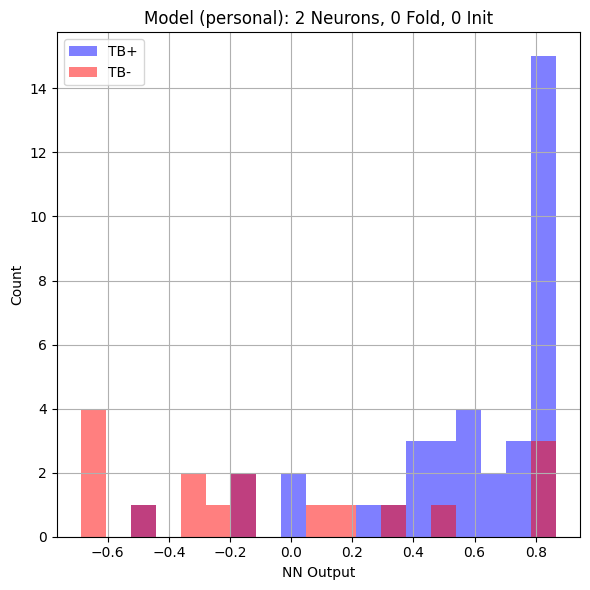

Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


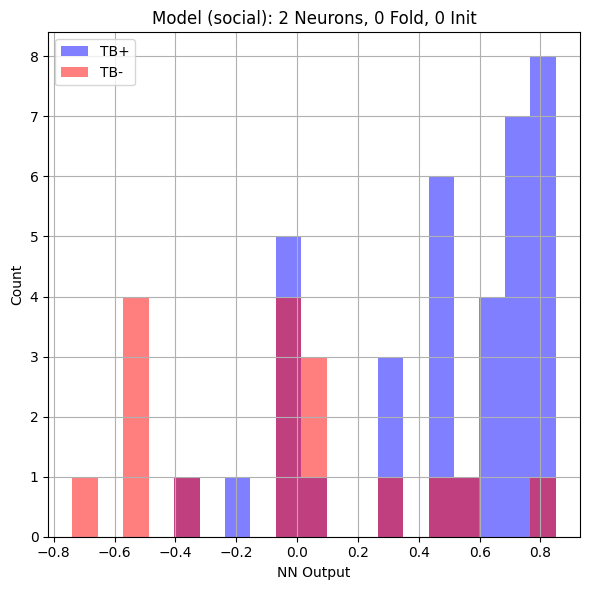

Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


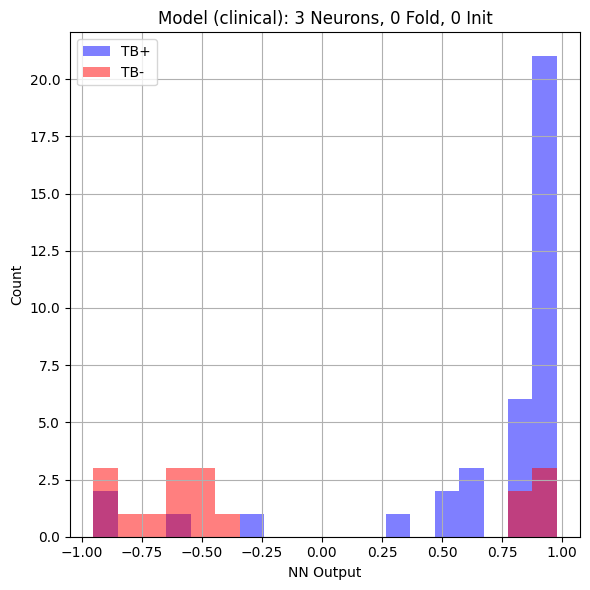

Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


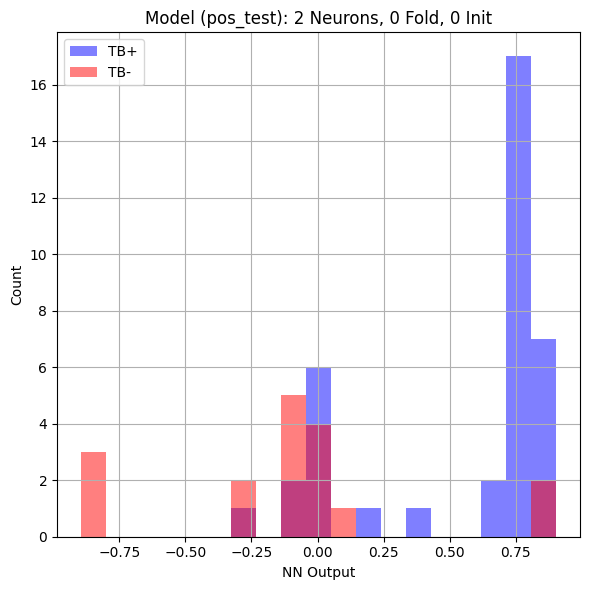

Processing PeSo
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


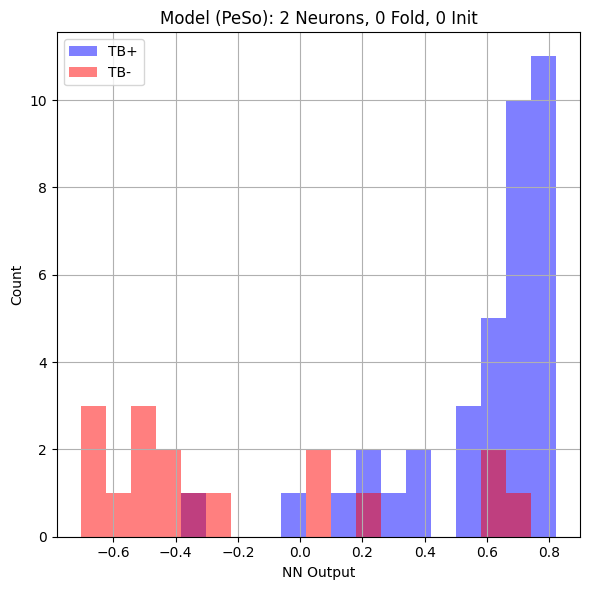

Processing PeSoCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


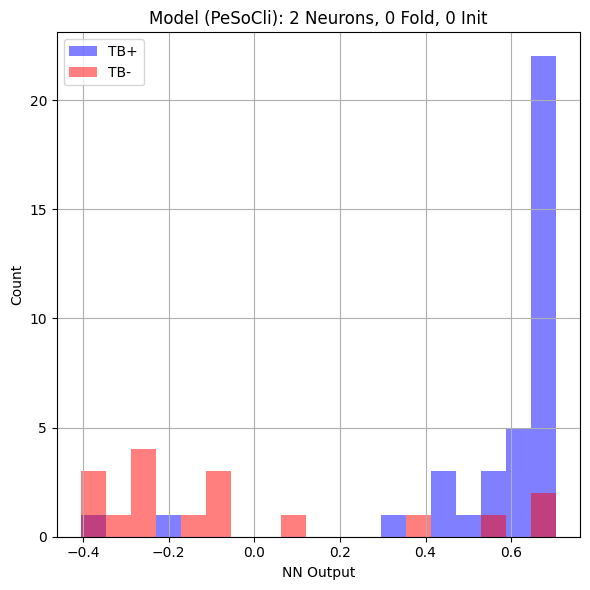

Processing PeCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


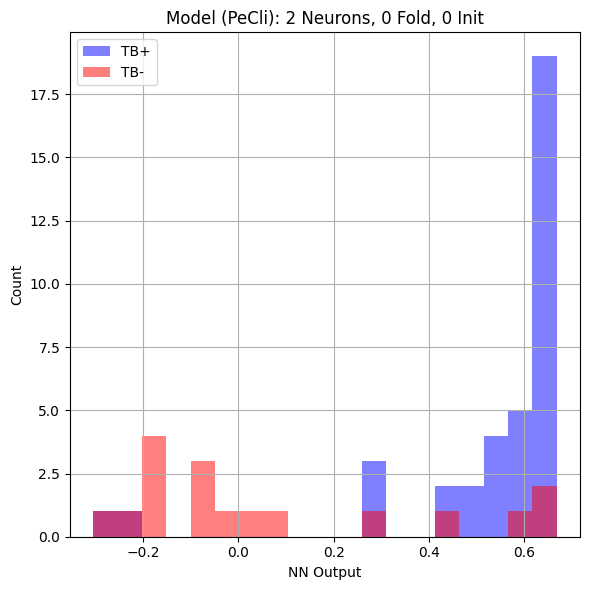

Processing CliPos
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


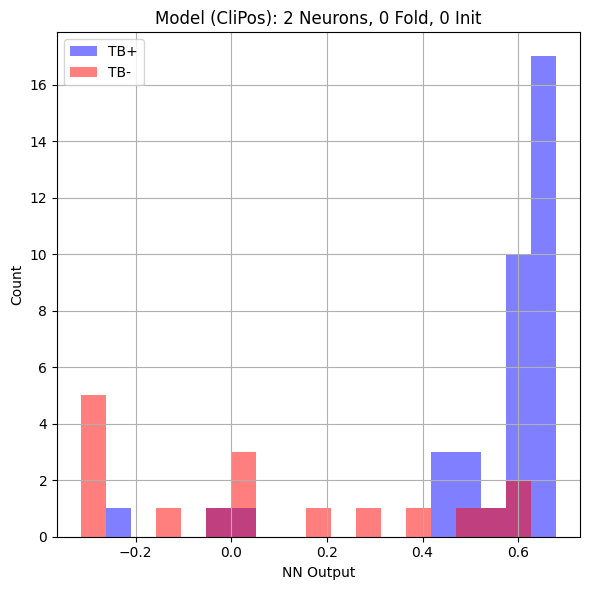

Processing PeSoCliPos_par
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


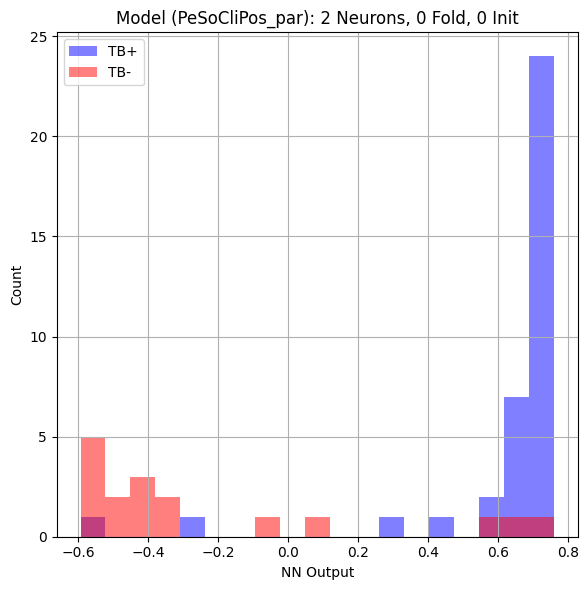

Analysing 2 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


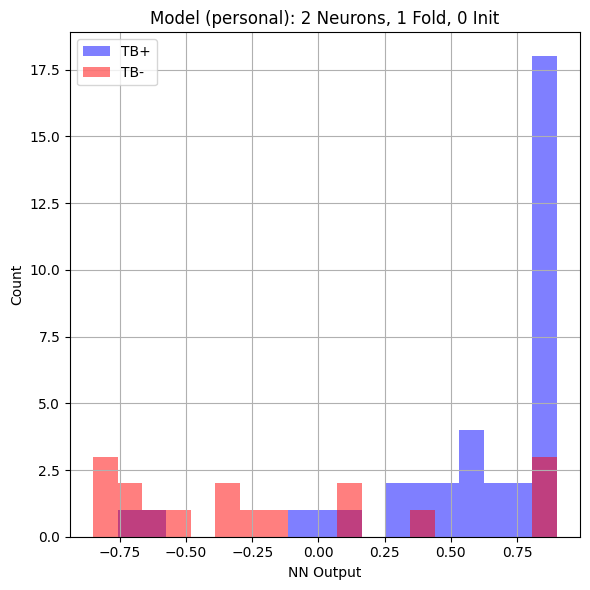

Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


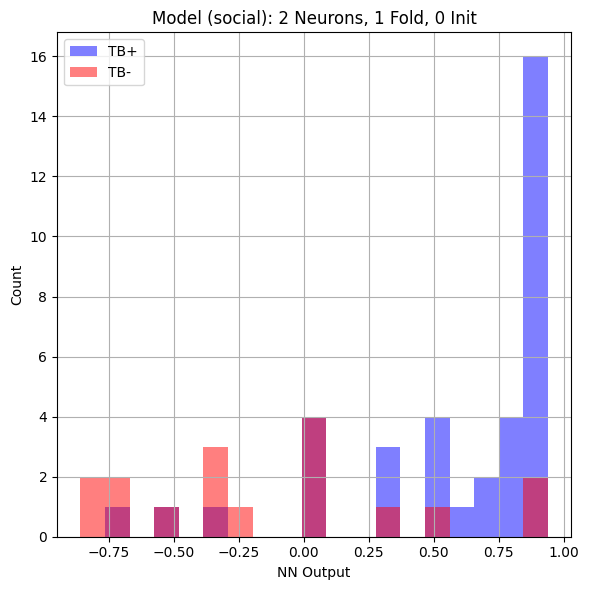

Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


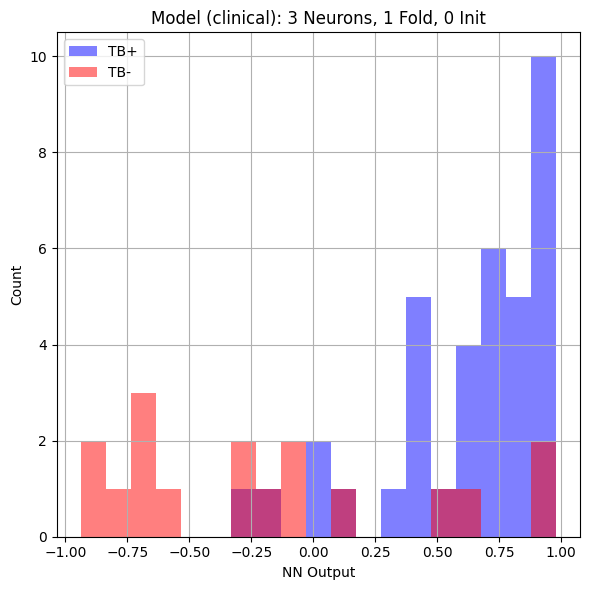

Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


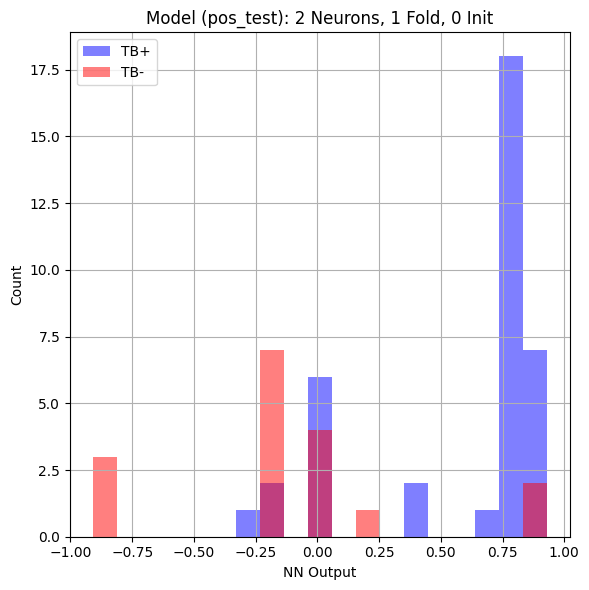

Processing PeSo
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


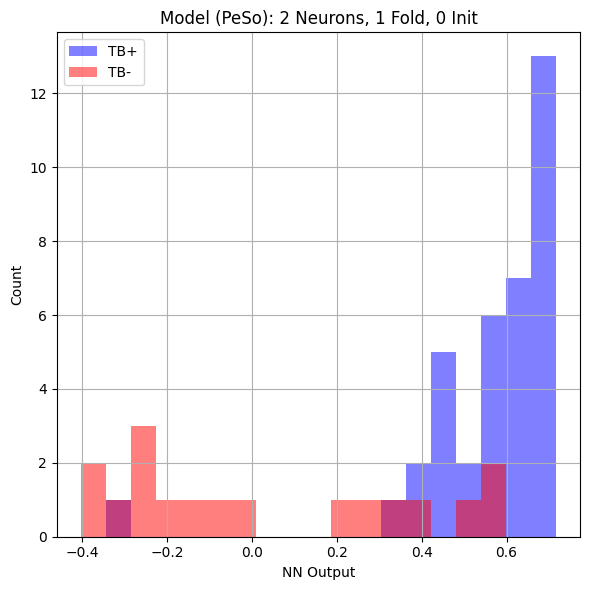

Processing PeSoCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


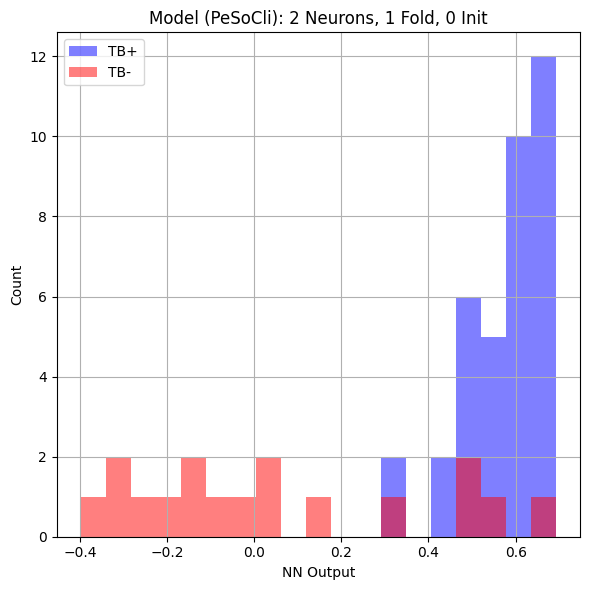

Processing PeCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


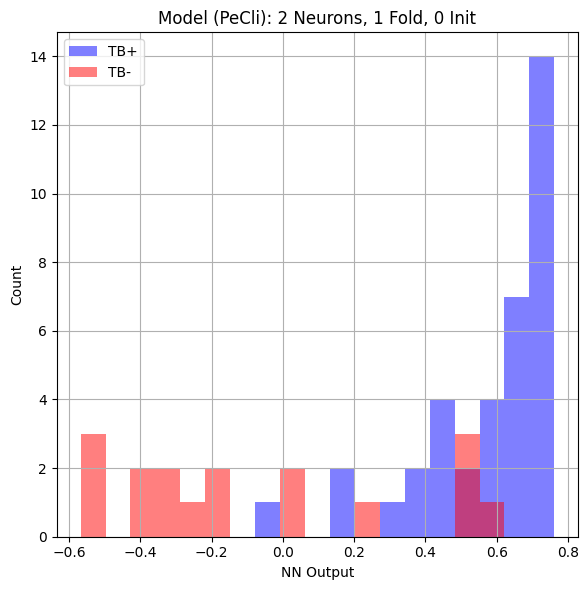

Processing CliPos
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


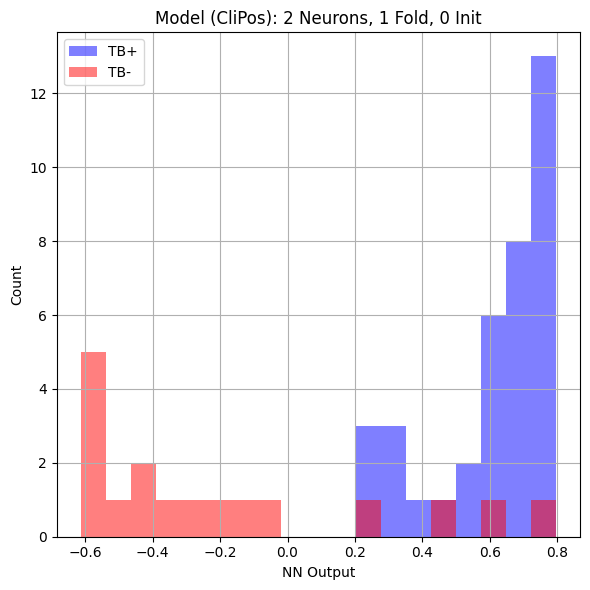

Processing PeSoCliPos_par
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


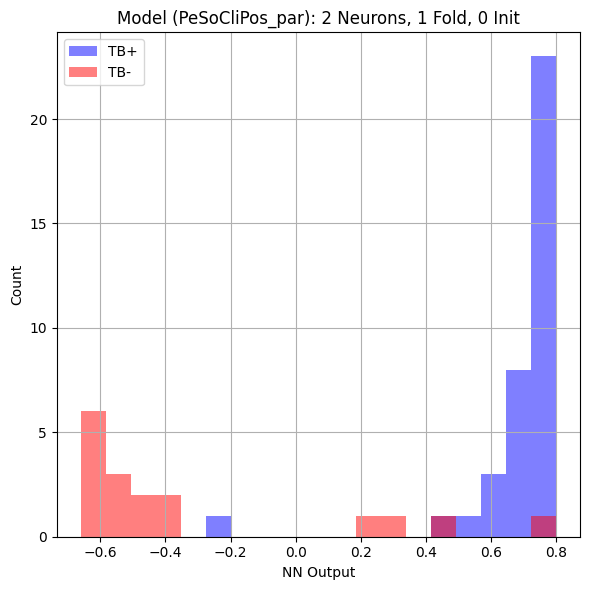

Analysing 3 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


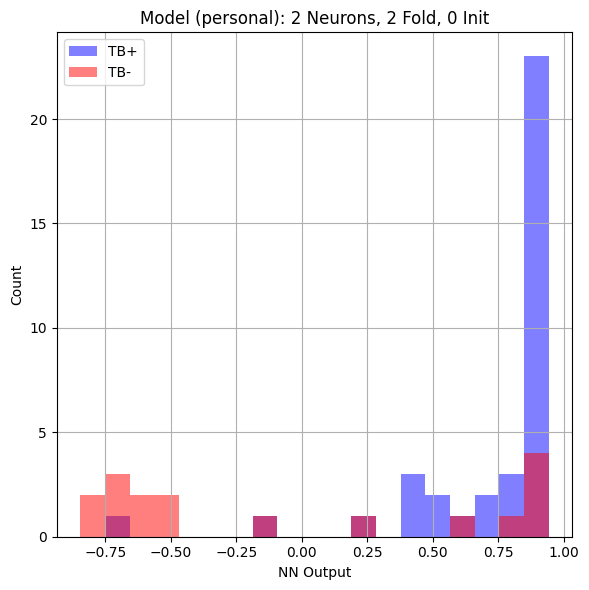

Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


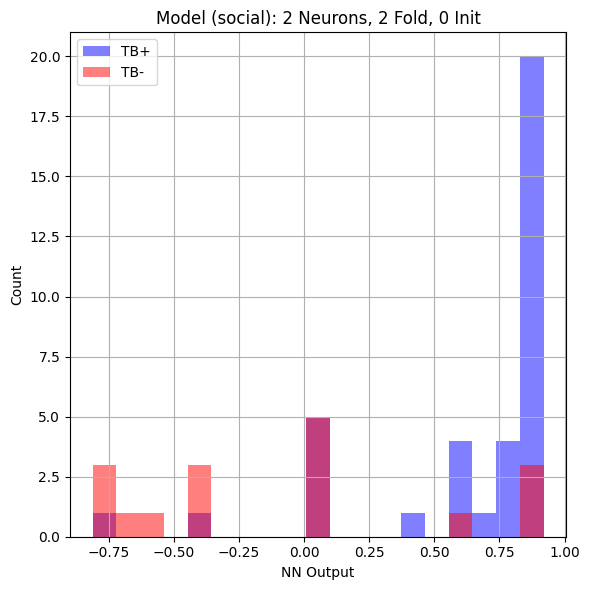

Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


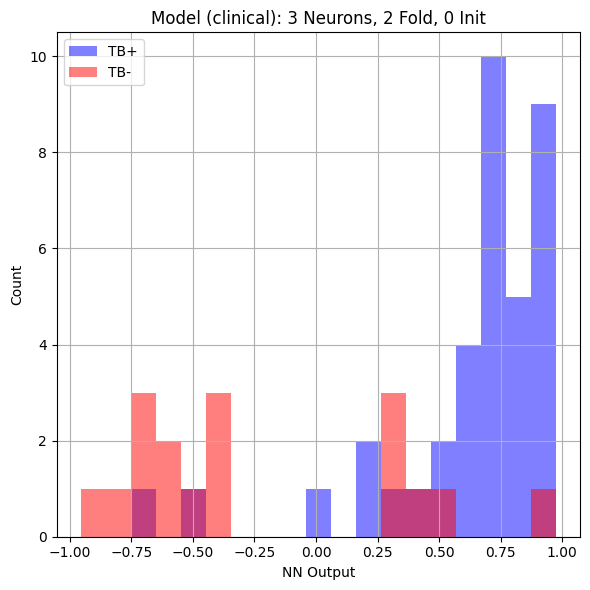

Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


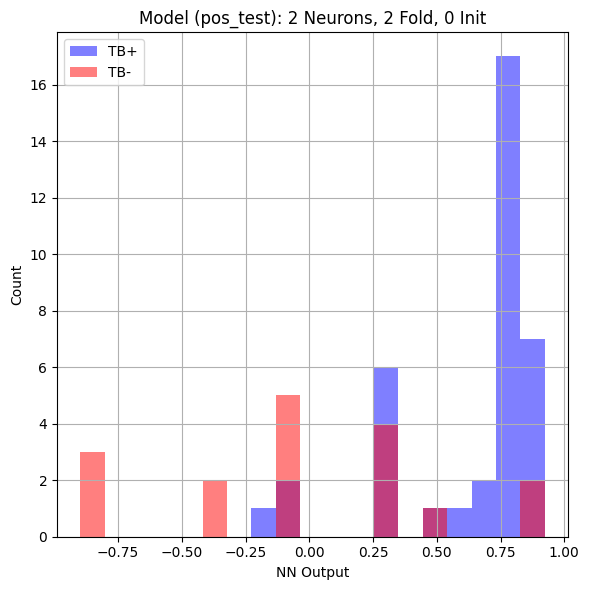

Processing PeSo
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


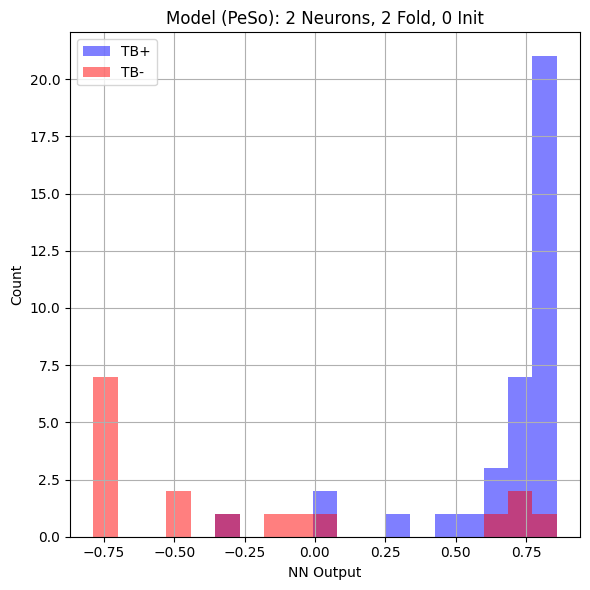

Processing PeSoCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


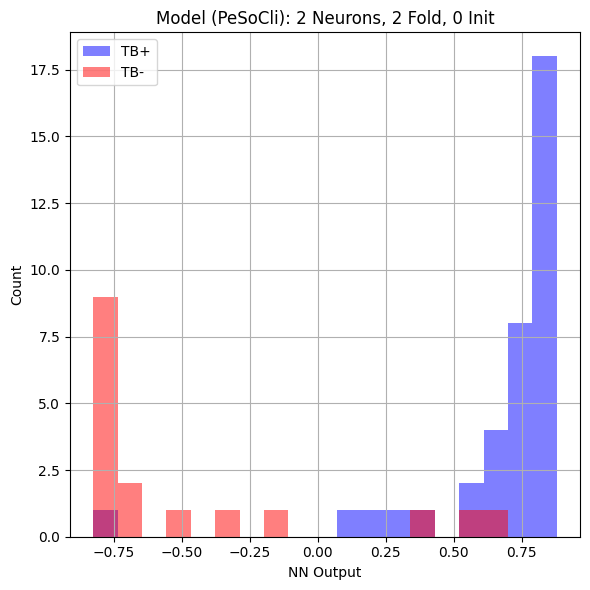

Processing PeCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


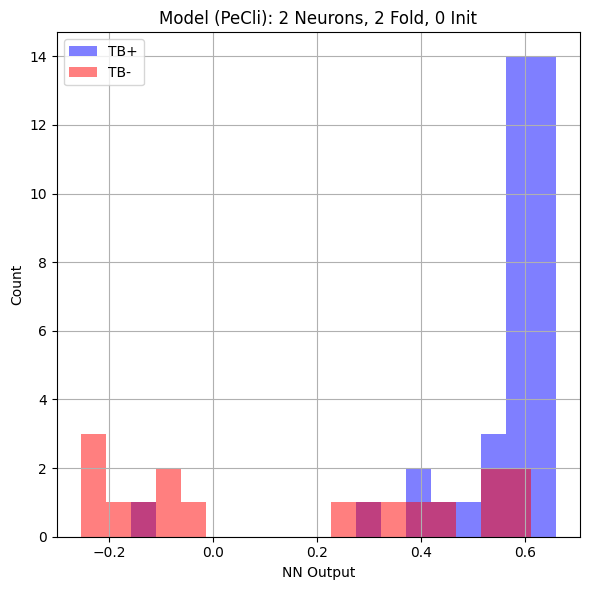

Processing CliPos
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


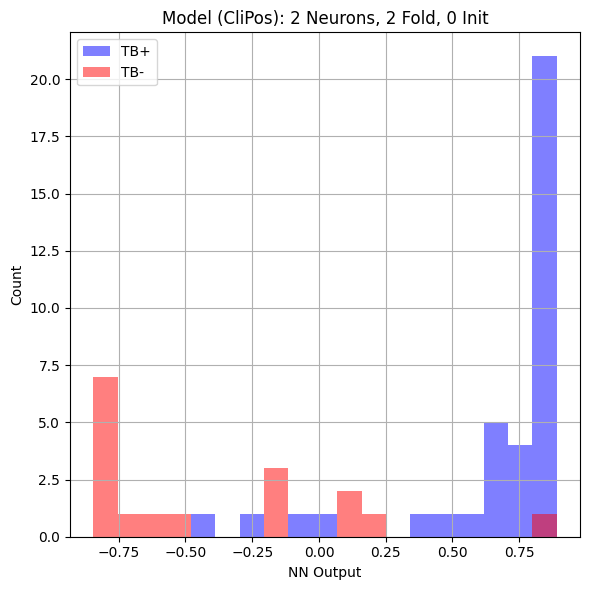

Processing PeSoCliPos_par
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


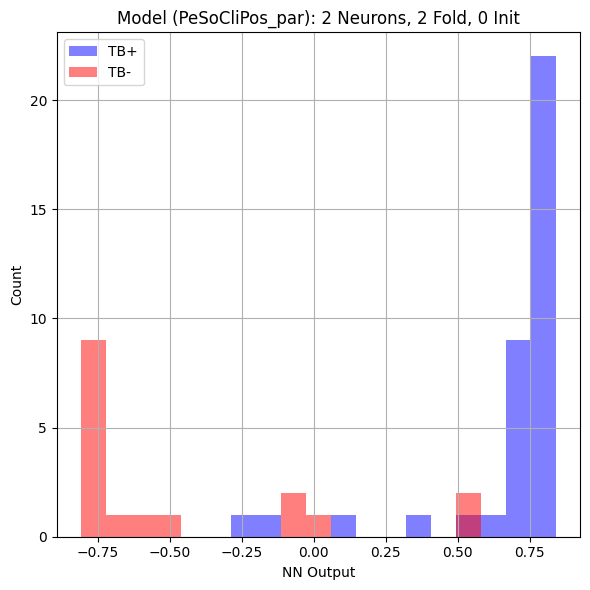

Analysing 4 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


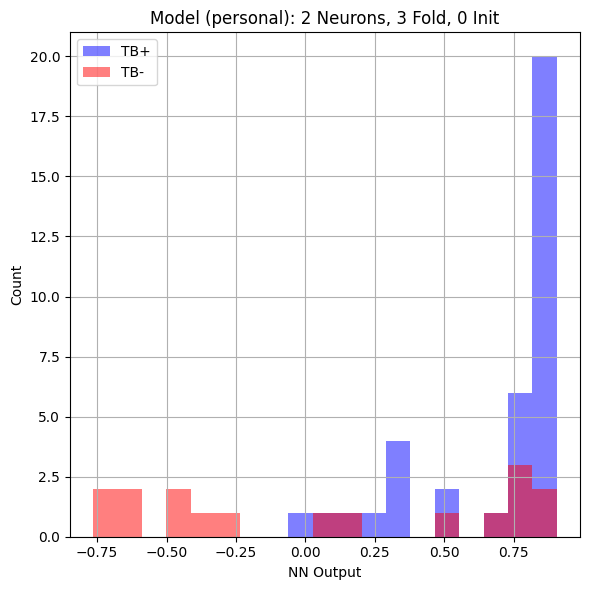

Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


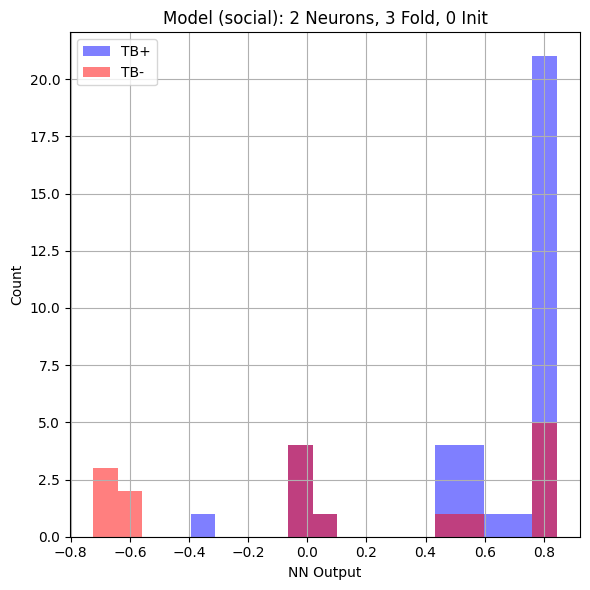

Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


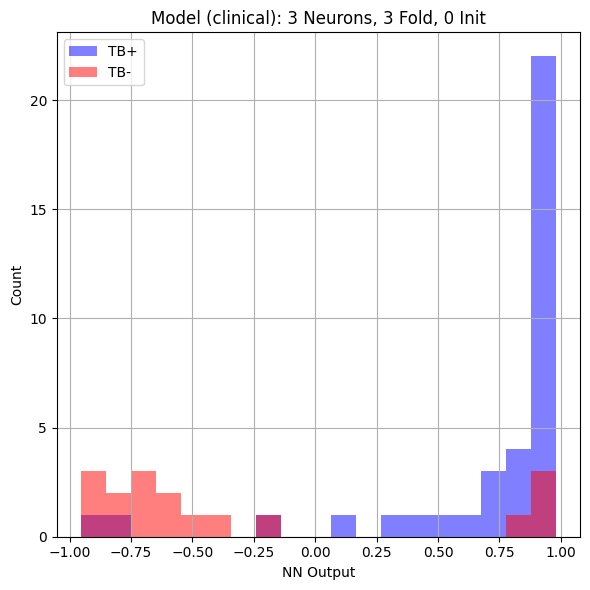

Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


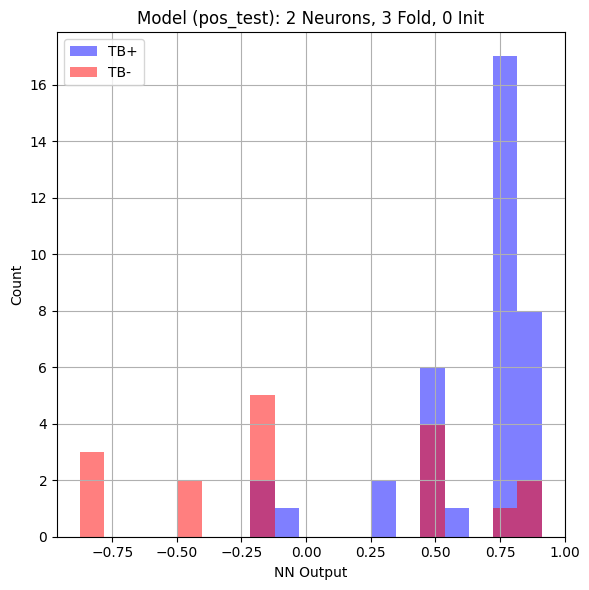

Processing PeSo
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


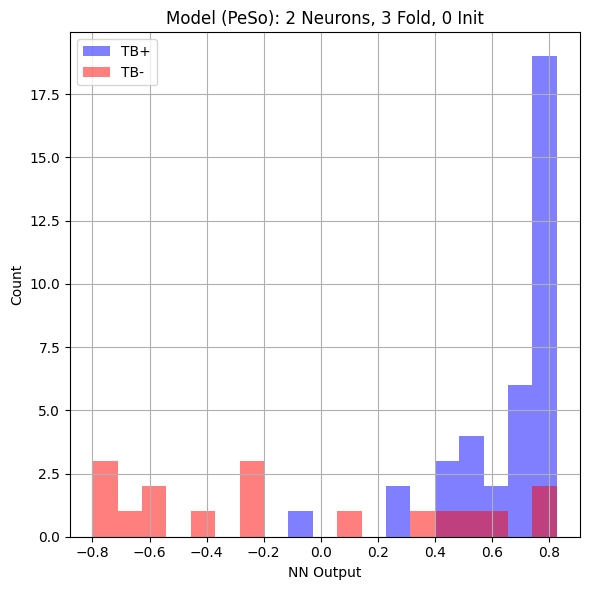

Processing PeSoCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


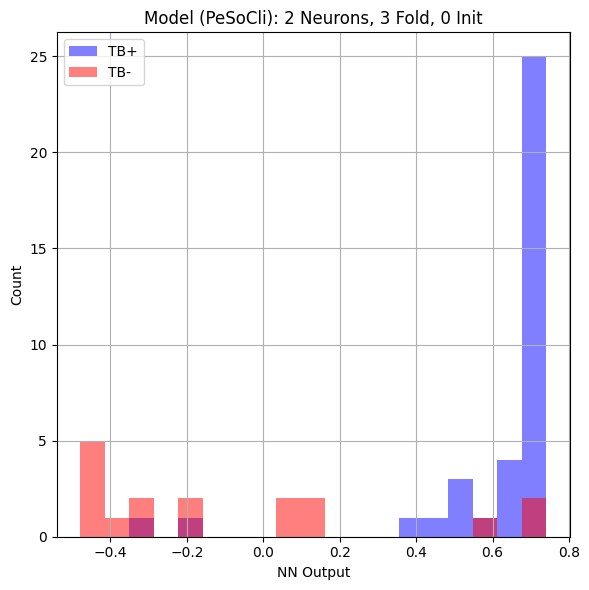

Processing PeCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


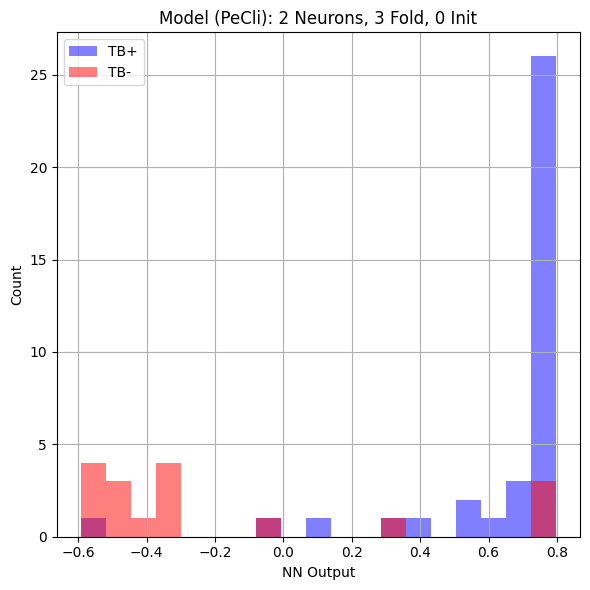

Processing CliPos
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


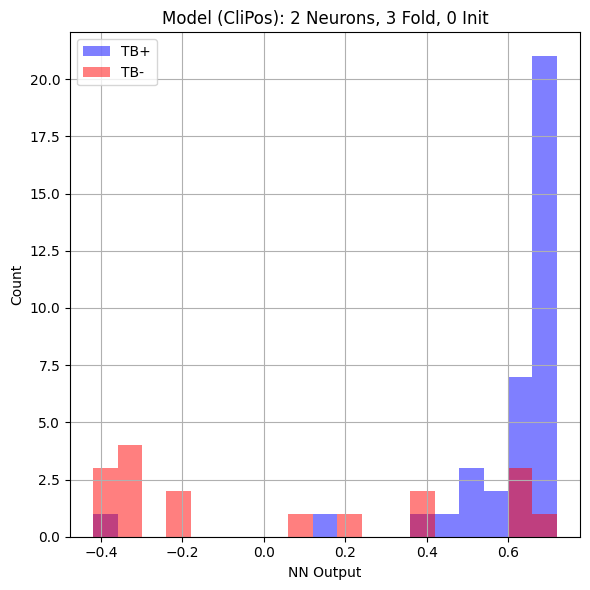

Processing PeSoCliPos_par
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


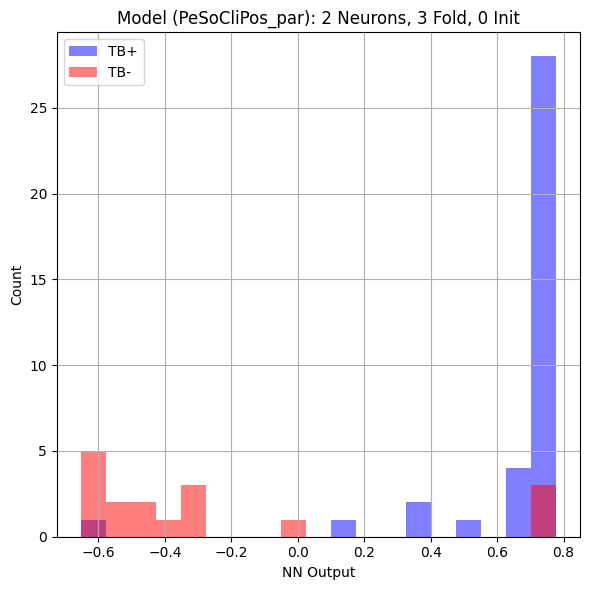

Analysing 5 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


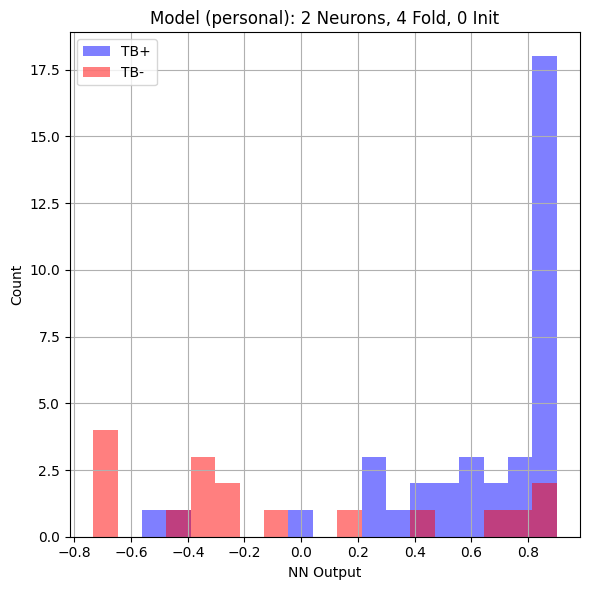

Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


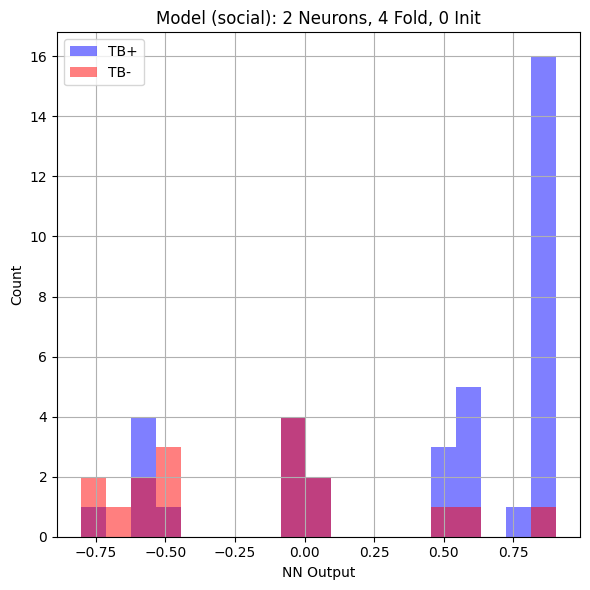

Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


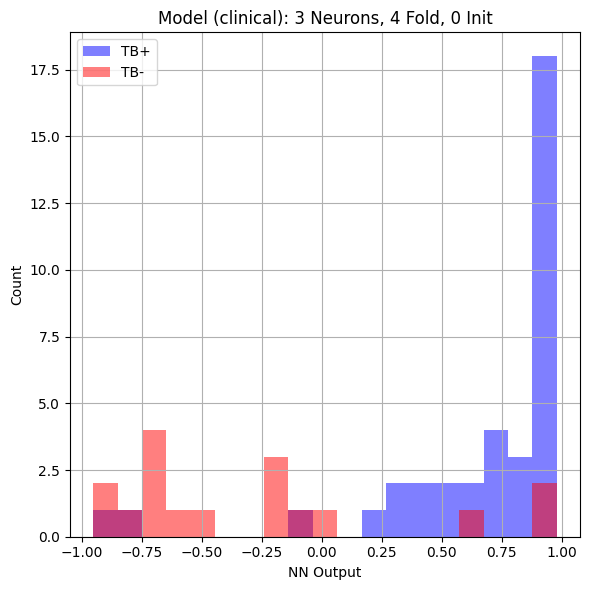

Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


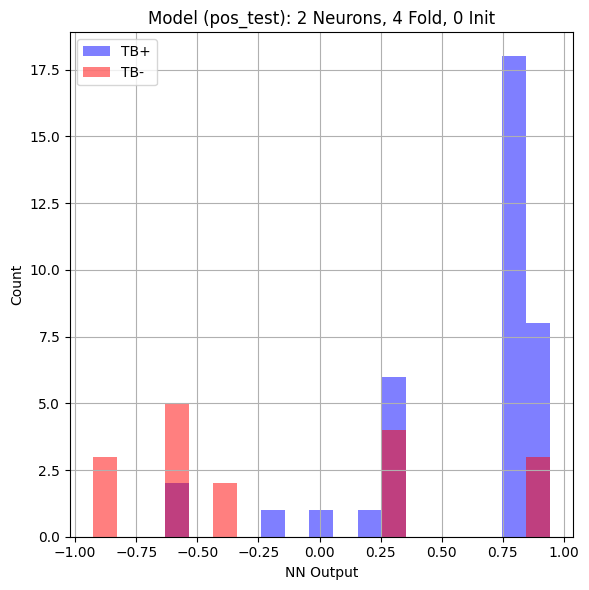

Processing PeSo
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


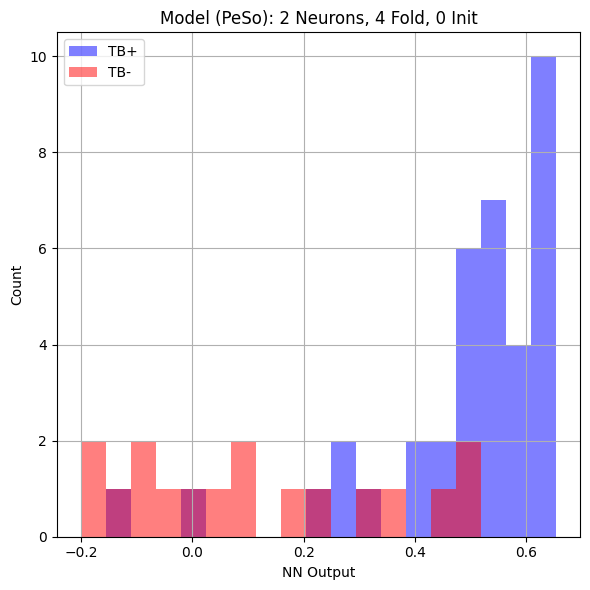

Processing PeSoCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


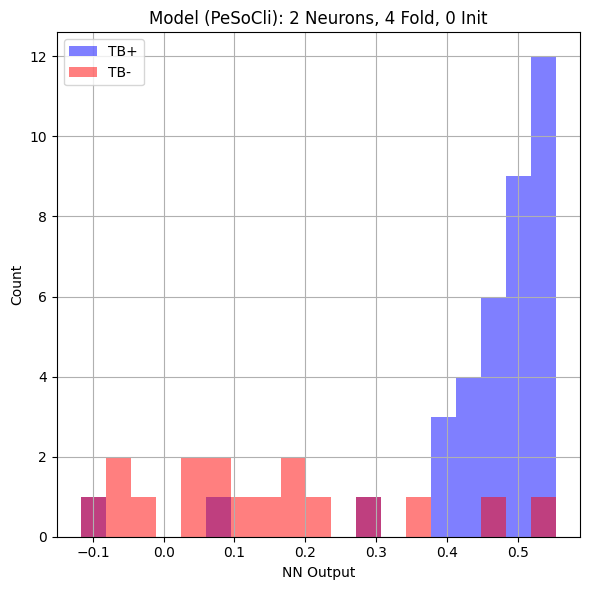

Processing PeCli
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


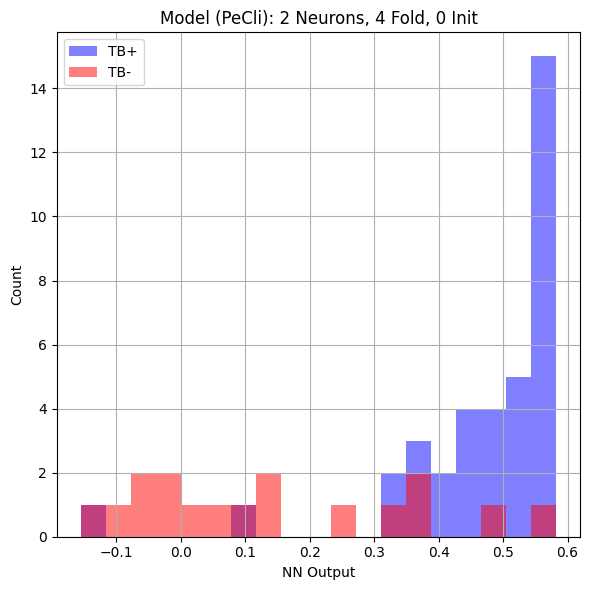

Processing CliPos
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


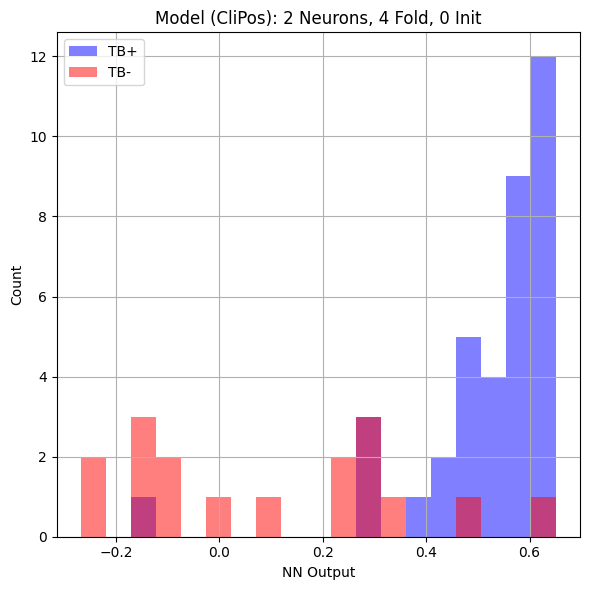

Processing PeSoCliPos_par
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSoCliPos_par.pkl
(54, 3)


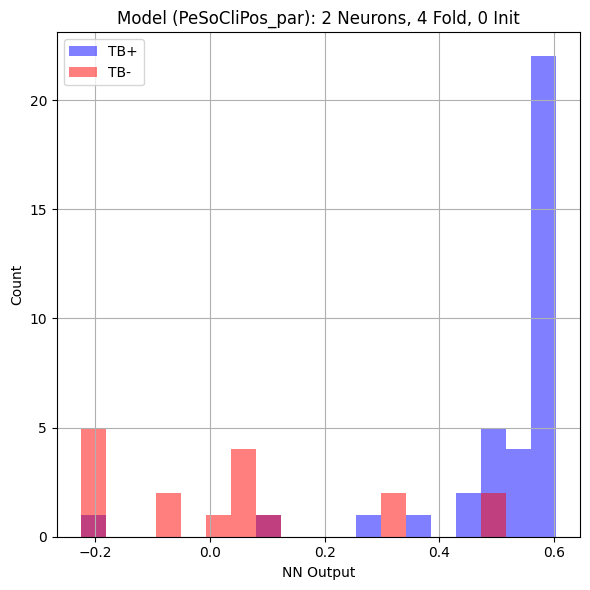

In [14]:
model_type = 'MLPNeuralNetwork'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]

n_folds = df_config['cv_folds'][train_id]
hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))

datasets_name = ['personal', 'social', 'clinical', 'pos_test', 'PeSo', 'PeSoCli', 'PeCli', 'CliPos', 'PeSoCliPos_par']

# numero de neuronios de cada modelo que vai realizar a fusão
previous_neuron = [2, 2, 3, 2, 2, 2, 2, 2, 2]
previous_init = [0, 0, 0, 0, 0, 0, 0, 0, 0]
df_fusion = pd.DataFrame()

print(get_train_description(df_config, train_id))

for ifold in range(n_folds):
    #if ifold != 0: # para desenvolvimento
    #    break
    print('Analysing %i fold of %i folds\n\n'%(ifold+1, n_folds))
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
        
    # agora eu tenho que fazer a saída de cada um dos modelos base e gerar um banco novo
    for idataset, dataset_name in enumerate(datasets_name):  
        print('Processing %s'%(dataset_name))
       
        model_path = df_config['model_path'][train_id]
        if os.path.exists(os.path.join(model_path, model_name)):
            print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            prediction_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                                        model_type,ifold, 
                                                                                        previous_neuron[idataset], 
                                                                                        previous_init[idataset],
                                                                                        dataset_name)
            df_predict = pd.read_csv(os.path.join(model_path, prediction_name))
            print(df_predict.shape)
            m_bins = np.linspace(df_predict['nn_output'].min(),
                                 df_predict['nn_output'].max(),
                                 20)
            
            pos_class_data = df_predict['nn_output'].loc[df_predict['target']==1].values
            neg_class_data = df_predict['nn_output'].loc[df_predict['target']!=1].values
            
            
            fig, ax = plt.subplots(figsize=(6, 6))
            n, bins, patches = ax.hist(pos_class_data, m_bins, facecolor='blue', alpha=0.5, label='TB+')
            n, bins, patches = ax.hist(neg_class_data, m_bins, facecolor='red', alpha=0.5, label='TB-')
            ax.set_xlabel('NN Output')
            ax.set_ylabel('Count')
            ax.set_title('Model (%s): %i Neurons, %i Fold, %i Init'%(dataset_name, 
                                                                     previous_neuron[idataset],
                                                                     ifold,
                                                                     previous_init[idataset]))
            ax.grid()
            ax.legend()
            plt.tight_layout()
            plt.show()
                
                
                

## O que mudou?

# Análise de Relevância

In [15]:
# for kFolds CV

from sklearn.metrics import accuracy_score
from AuxiliarFunctions import *
import Models
import joblib

print(get_train_description(df_config, train_id))

print('Analysis Starting')

datasets_data = [dev_social, dev_clinical, dev_pos_test, dev_personal]
datasets_name = ['social', 'clinical', 'pos_test', 'personal']

ineuron = [2,2,3,2]
iinit = 0

pipe_path = df_config['pipeline_path'][train_id]

#figure_of_merit_relevance_refence = np.zeros((len(datasets_data),n_folds,1))
#figure_of_merit_relevance_matrix = np.zeros((len(datasets_data),n_folds,data.shape[1]))

figure_of_merit_relevance_refence = {}
figure_of_merit_relevance_matrix = {}
for idataset, dataset_name in enumerate(datasets_name): 
    # data
    model_type = 'MLPNeuralNetwork'
    data = datasets_data[idataset]
    print('Data shape: (%i, %i)'%(data.shape[0], data.shape[1]))

    trgt = dev_target.values
    print('Trgt shape: %i'%(trgt.shape[0]))

    hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))

    with open(df_config['model_status'][train_id],'rb') as file_handler:
        [model_status] = pickle.load(file_handler)


    n_folds = df_config['cv_folds'][train_id]
    model_hidden_neurons = 100 
    
    model_relevance_matrix = np.zeros((data.shape[1]+1, n_folds))
    relevance = np.zeros((data.shape[1], n_folds))
    relative_relevance = np.zeros((data.shape[1], n_folds))
    
    #figure_of_merit_relevance_refence[idataset] = np.zeros((n_folds,1))
    #figure_of_merit_relevance_matrix[idataset] = np.zeros((n_folds,data.shape[1]))

    for ifold in range(n_folds):
        print('Analysing %i fold of %i folds'%(ifold+1, n_folds))
        # pipeline
        pipe_name = '%s_%s_CV_fold_%i_of_%i_pipe_%s.jbl'%(df_config['hash_id'][train_id],
                                                          df_config['cv_alg'][train_id],
                                                          ifold, n_folds, 
                                                          datasets_name[idataset])
        with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)

        trn_data = pipe.transform(data)
        trn_trgt = tf.keras.utils.to_categorical(trgt, num_classes=len(np.unique(trgt)))


        print('Analysing for %i neurons'%(model_hidden_neurons))

        model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                             model_type,ifold, 
                                                                             ineuron[idataset],iinit,
                                                                             datasets_name[idataset])
        model_path = df_config['model_path'][train_id]    
        
        if not os.path.exists(os.path.join(model_path, model_name)):    
            print('Modelo não existe\n')
            continue

        else:
            print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            model = Models.MLPModel(n_hidden_neurons=ineuron,verbose=2)
            model.load(os.path.join(model_path, model_name))
            predictions = model.predict(trn_data)
            predictions = np.sign(predictions)
            ref_value = accuracy_score(trgt,predictions)
            model_relevance_matrix[0,ifold] = ref_value
            #figure_of_merit_relevance_refence[idataset][ifold] = value
            print('Value of Figure of Merit (Acc): ',ref_value)

            for iinput in range(data.shape[1]):
                print('Analysing for %i input in'%(iinput),data.shape[1])
                buffer_data = np.copy(trn_data)
                buffer_data[:,iinput] = np.mean(buffer_data[:,iinput])
                predictions = model.predict(buffer_data)
                predictions = np.sign(predictions)
                value = Models.acc_score(trgt,predictions)
                model_relevance_matrix[iinput+1,ifold] = value
                print('Value of Figure of Merit (Acc): ',value)
                relevance[iinput,ifold] = ref_value - value
                relative_relevance[iinput,ifold] = (ref_value - value)/ref_value
    df_model_relevance_matrix = pd.DataFrame(data=model_relevance_matrix, columns=range(n_folds), 
                                             index=['All inputs'] + list(data.columns))
    df_model_relevance_matrix.to_csv(os.path.join(model_path, '%s_relevance_anal_mat.csv'%(dataset_name)))
    df_relevance = pd.DataFrame(data=relevance, 
                                columns=range(n_folds),
                                index=list(data.columns))
    df_relevance.to_csv(os.path.join(model_path, '%s_relevance_anal.csv'%(dataset_name)))
    df_relative_relevance = pd.DataFrame(data=relative_relevance, 
                                columns=range(n_folds),
                                index=list(data.columns))
    df_relative_relevance.to_csv(os.path.join(model_path, '%s_relative_relevance_anal.csv'%(dataset_name)))




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Analysis Starting
Data shape: (54, 13)
Trgt shape: 54
Analysing 1 fold of 5 folds
Analysing for 100 neurons
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 5ms/step
Value of Figure of Merit (Acc):  0.7407407407407407
Analysing for 0 input in 13
2/2 [==============================] - 0s 6ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 1 input in 13
2/2 [==============================] - 0s 4ms/step
Value of Figure of Merit (Acc):  0.7407407407407407
Analysing for 2 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7407407407407407
Analysing for 3 input in 13
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.75925925

2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 0 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 1 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 2 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 3 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 4 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.6481481481481481
Analysing for 5 input in 13
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 6 input in 13
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc): 

2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.8148148148148148
Analysing for 11 input in 16
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7962962962962963
Analysing for 12 input in 16
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.8333333333333334
Analysing for 13 input in 16
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.8333333333333334
Analysing for 14 input in 16
2/2 [==============================] - 0s 4ms/step
Value of Figure of Merit (Acc):  0.7962962962962963
Analysing for 15 input in 16
2/2 [==============================] - 0s 5ms/step
Value of Figure of Merit (Acc):  0.8148148148148148
Analysing 4 fold of 5 folds
Analysing for 100 neurons
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 3ms/step
Value of Figure of Me

2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 1 input in 4
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.6296296296296297
Analysing for 2 input in 4
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 3 input in 4
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7962962962962963
Analysing 5 fold of 5 folds
Analysing for 100 neurons
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_3_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.7962962962962963
Analysing for 0 input in 4
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 1 input in 4
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):

2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.7592592592592593
Analysing for 3 input in 10
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.8518518518518519
Analysing for 4 input in 10
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7962962962962963
Analysing for 5 input in 10
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.8333333333333334
Analysing for 6 input in 10
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.8148148148148148
Analysing for 7 input in 10
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7592592592592593
Analysing for 8 input in 10
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.8518518518518519
Analysing for 9 input in 10
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc): 

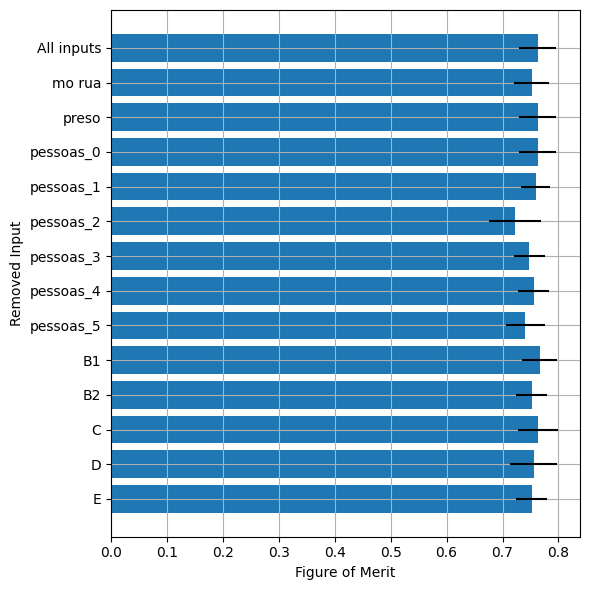

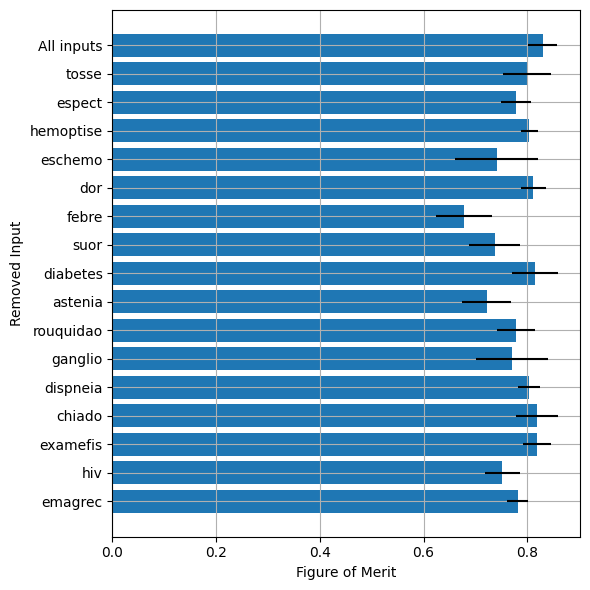

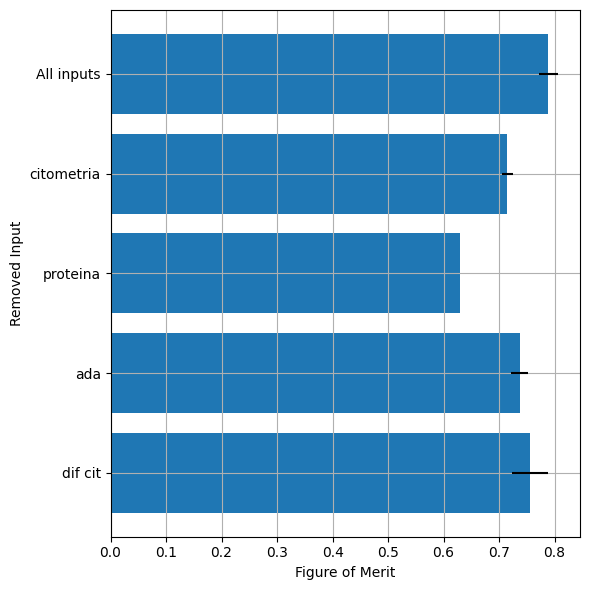

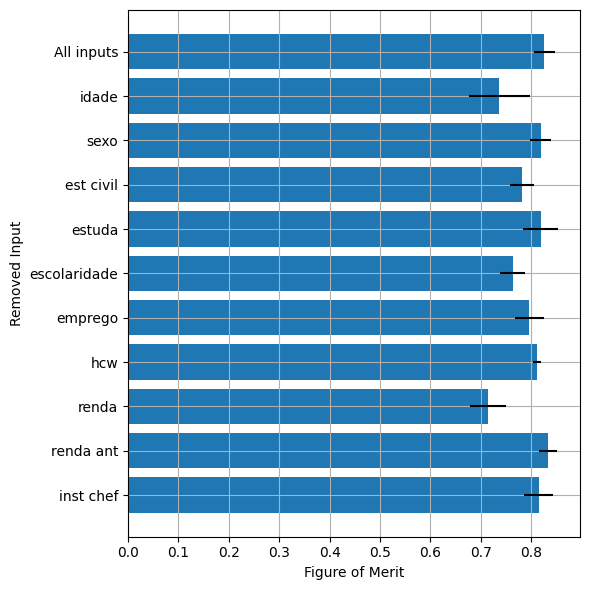

In [16]:
import matplotlib.pyplot as plt


datasets_data = [dev_social, dev_clinical, dev_pos_test, dev_personal]
datasets_name = ['social', 'clinical', 'pos_test', 'personal']


for idataset, dataset_name in enumerate(datasets_name): 
    fig, ax = plt.subplots(figsize=(6, 6)) 
    
    data = datasets_data[idataset]
    
    df_model_relevance_matrix = pd.read_csv(os.path.join(model_path, '%s_relevance_anal_mat.csv'%(dataset_name)),index_col=0)
    
    y = np.arange(df_model_relevance_matrix.shape[0])
    x = df_model_relevance_matrix.mean(axis=1).values
    x_err = df_model_relevance_matrix.std(axis=1).values
    
    ax.barh(y, x, xerr=x_err, align='center')
    
    ax.set_yticks(y, labels=df_model_relevance_matrix.index.values)
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.set_xlabel('Figure of Merit')
    ax.set_ylabel('Removed Input')
    plt.tight_layout()
    
    plt.grid()
    plt.show()

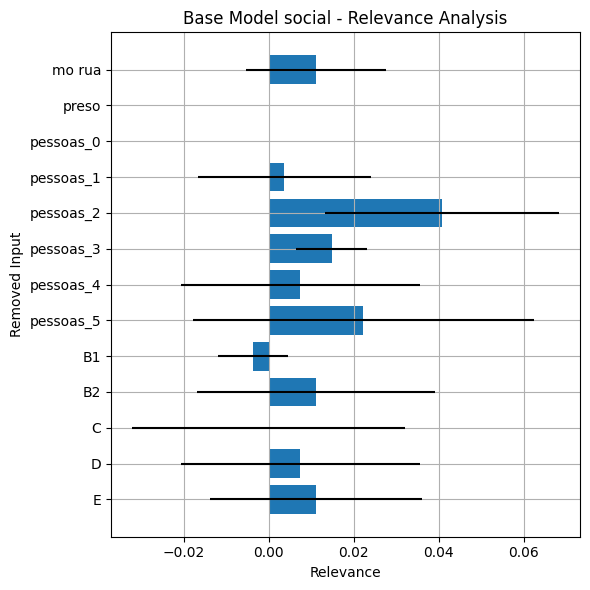

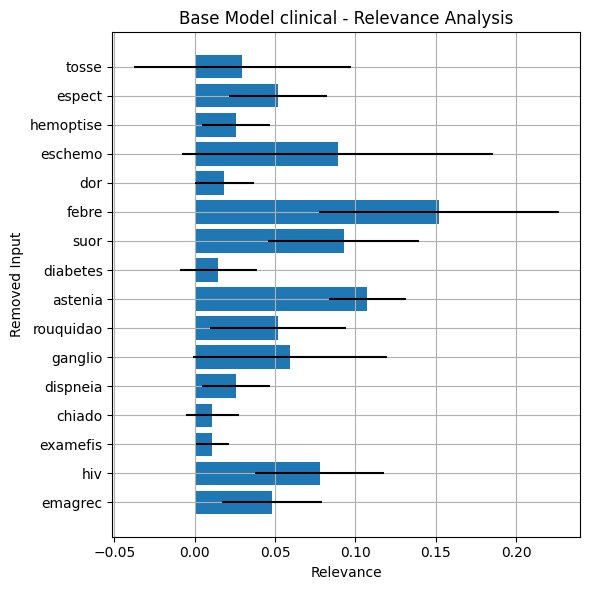

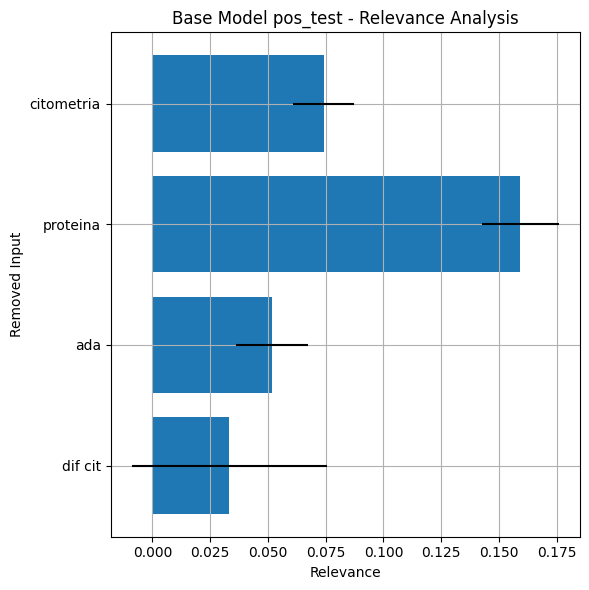

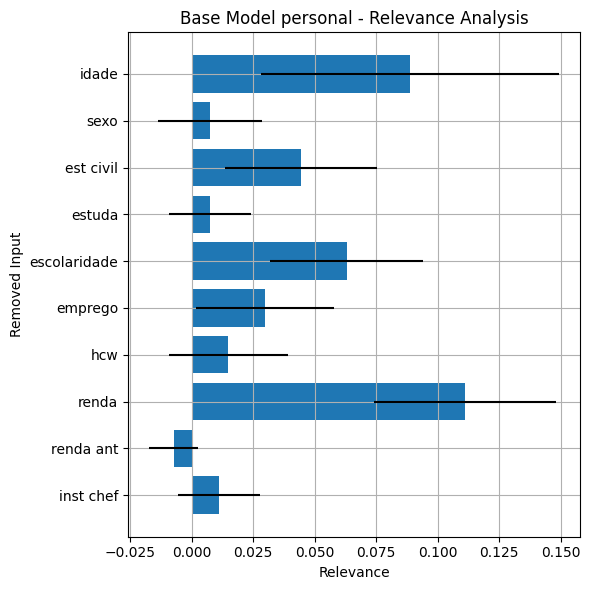

In [17]:
import matplotlib.pyplot as plt


datasets_data = [dev_social, dev_clinical, dev_pos_test, dev_personal]
datasets_name = ['social', 'clinical', 'pos_test', 'personal']


for idataset, dataset_name in enumerate(datasets_name): 
    fig, ax = plt.subplots(figsize=(6, 6)) 
    
    data = datasets_data[idataset]
    
    df_model_relevance_matrix = pd.read_csv(os.path.join(model_path, '%s_relevance_anal.csv'%(dataset_name)),index_col=0)
    
    y = np.arange(df_model_relevance_matrix.shape[0])
    x = df_model_relevance_matrix.mean(axis=1).values
    x_err = df_model_relevance_matrix.std(axis=1).values
    
    ax.barh(y, x, xerr=x_err, align='center')
    
    ax.set_yticks(y, labels=df_model_relevance_matrix.index.values)
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.set_xlabel('Relevance')
    ax.set_ylabel('Removed Input')
    ax.set_title('Base Model %s - Relevance Analysis'%(dataset_name))
    plt.tight_layout()
    
    plt.grid()
    plt.show()

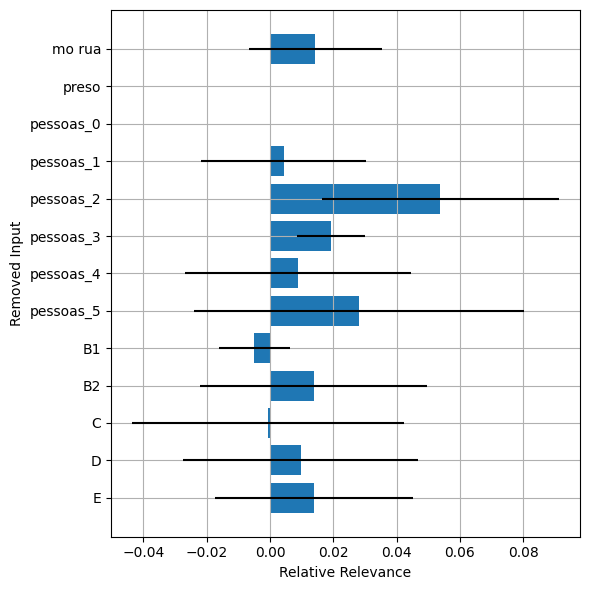

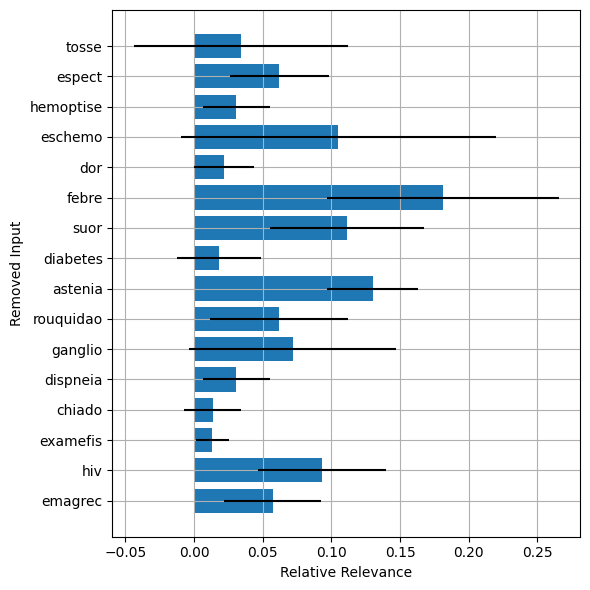

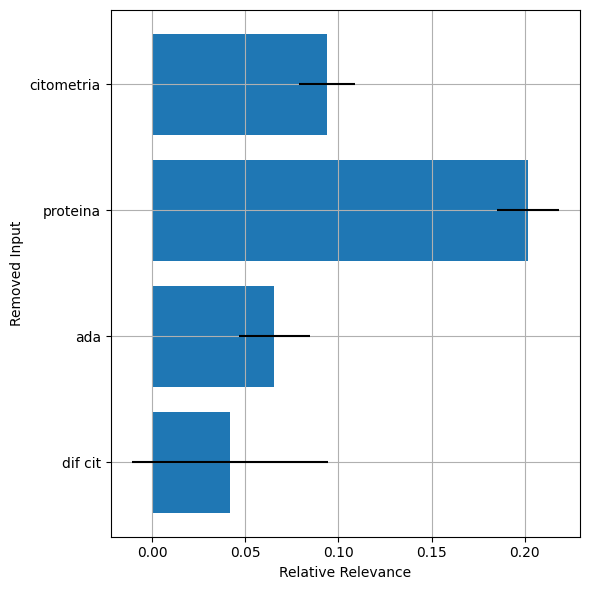

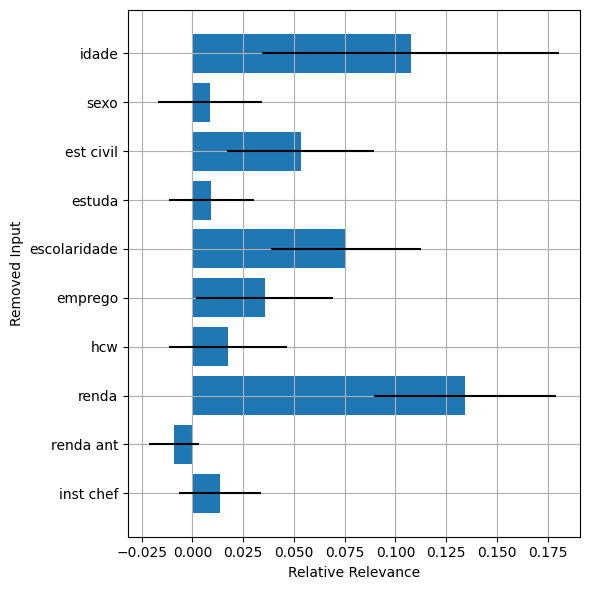

In [18]:
import matplotlib.pyplot as plt


datasets_data = [dev_social, dev_clinical, dev_pos_test, dev_personal]
datasets_name = ['social', 'clinical', 'pos_test', 'personal']


for idataset, dataset_name in enumerate(datasets_name): 
    fig, ax = plt.subplots(figsize=(6, 6)) 
    
    data = datasets_data[idataset]
    
    df_model_relevance_matrix = pd.read_csv(os.path.join(model_path, '%s_relative_relevance_anal.csv'%(dataset_name)),index_col=0)
    
    y = np.arange(df_model_relevance_matrix.shape[0])
    x = df_model_relevance_matrix.mean(axis=1).values
    x_err = df_model_relevance_matrix.std(axis=1).values
    
    ax.barh(y, x, xerr=x_err, align='center')
    
    ax.set_yticks(y, labels=df_model_relevance_matrix.index.values)
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.set_xlabel('Relative Relevance')
    ax.set_ylabel('Removed Input')
    plt.tight_layout()
    
    plt.grid()
    plt.show()

# Scatter Plots

Seixas pediu um scatter plot de todas as variáveis. Como fazer isso e como analisar?

<ipython-input-24-dee3149ebeec>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(dev_social, alpha=0.2, ax=ax)


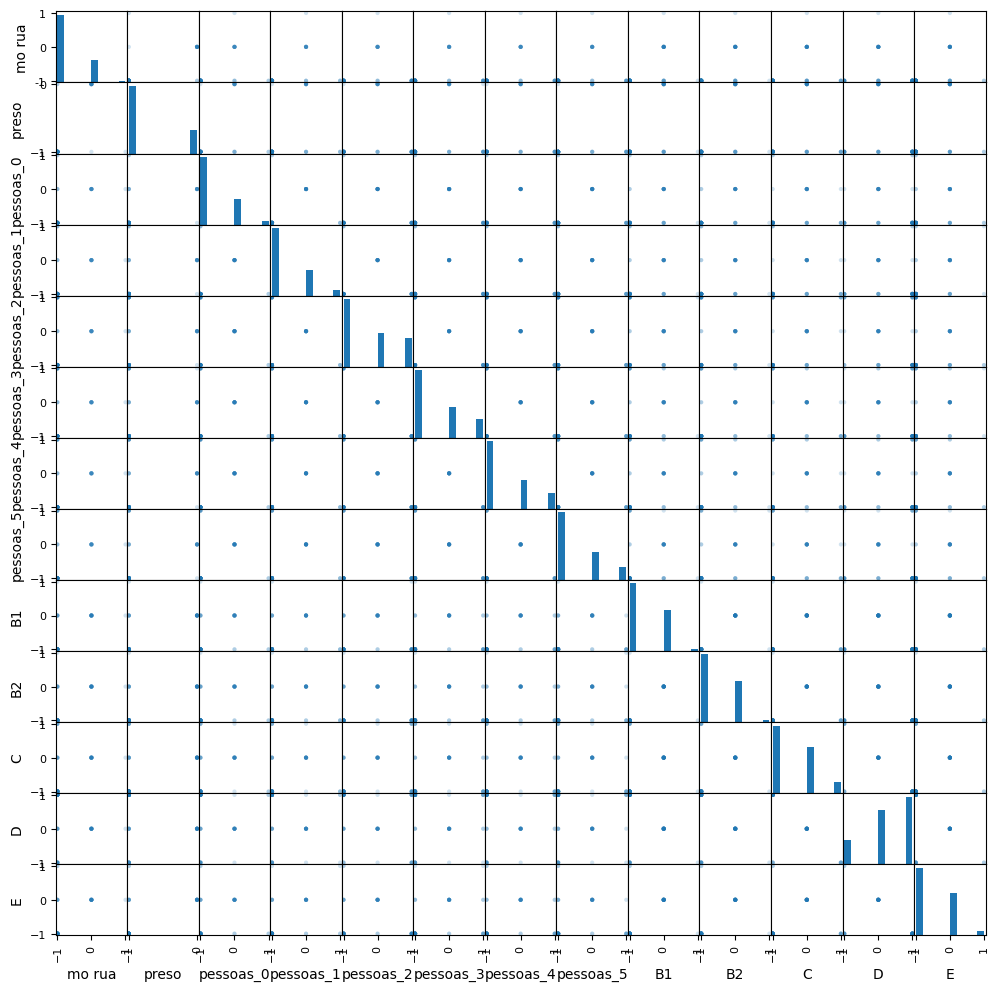

In [24]:
fig, ax = plt.subplots(figsize=(12, 12)) 
   
pd.plotting.scatter_matrix(dev_social, alpha=0.2, ax=ax)
plt.show()

<Figure size 640x480 with 0 Axes>

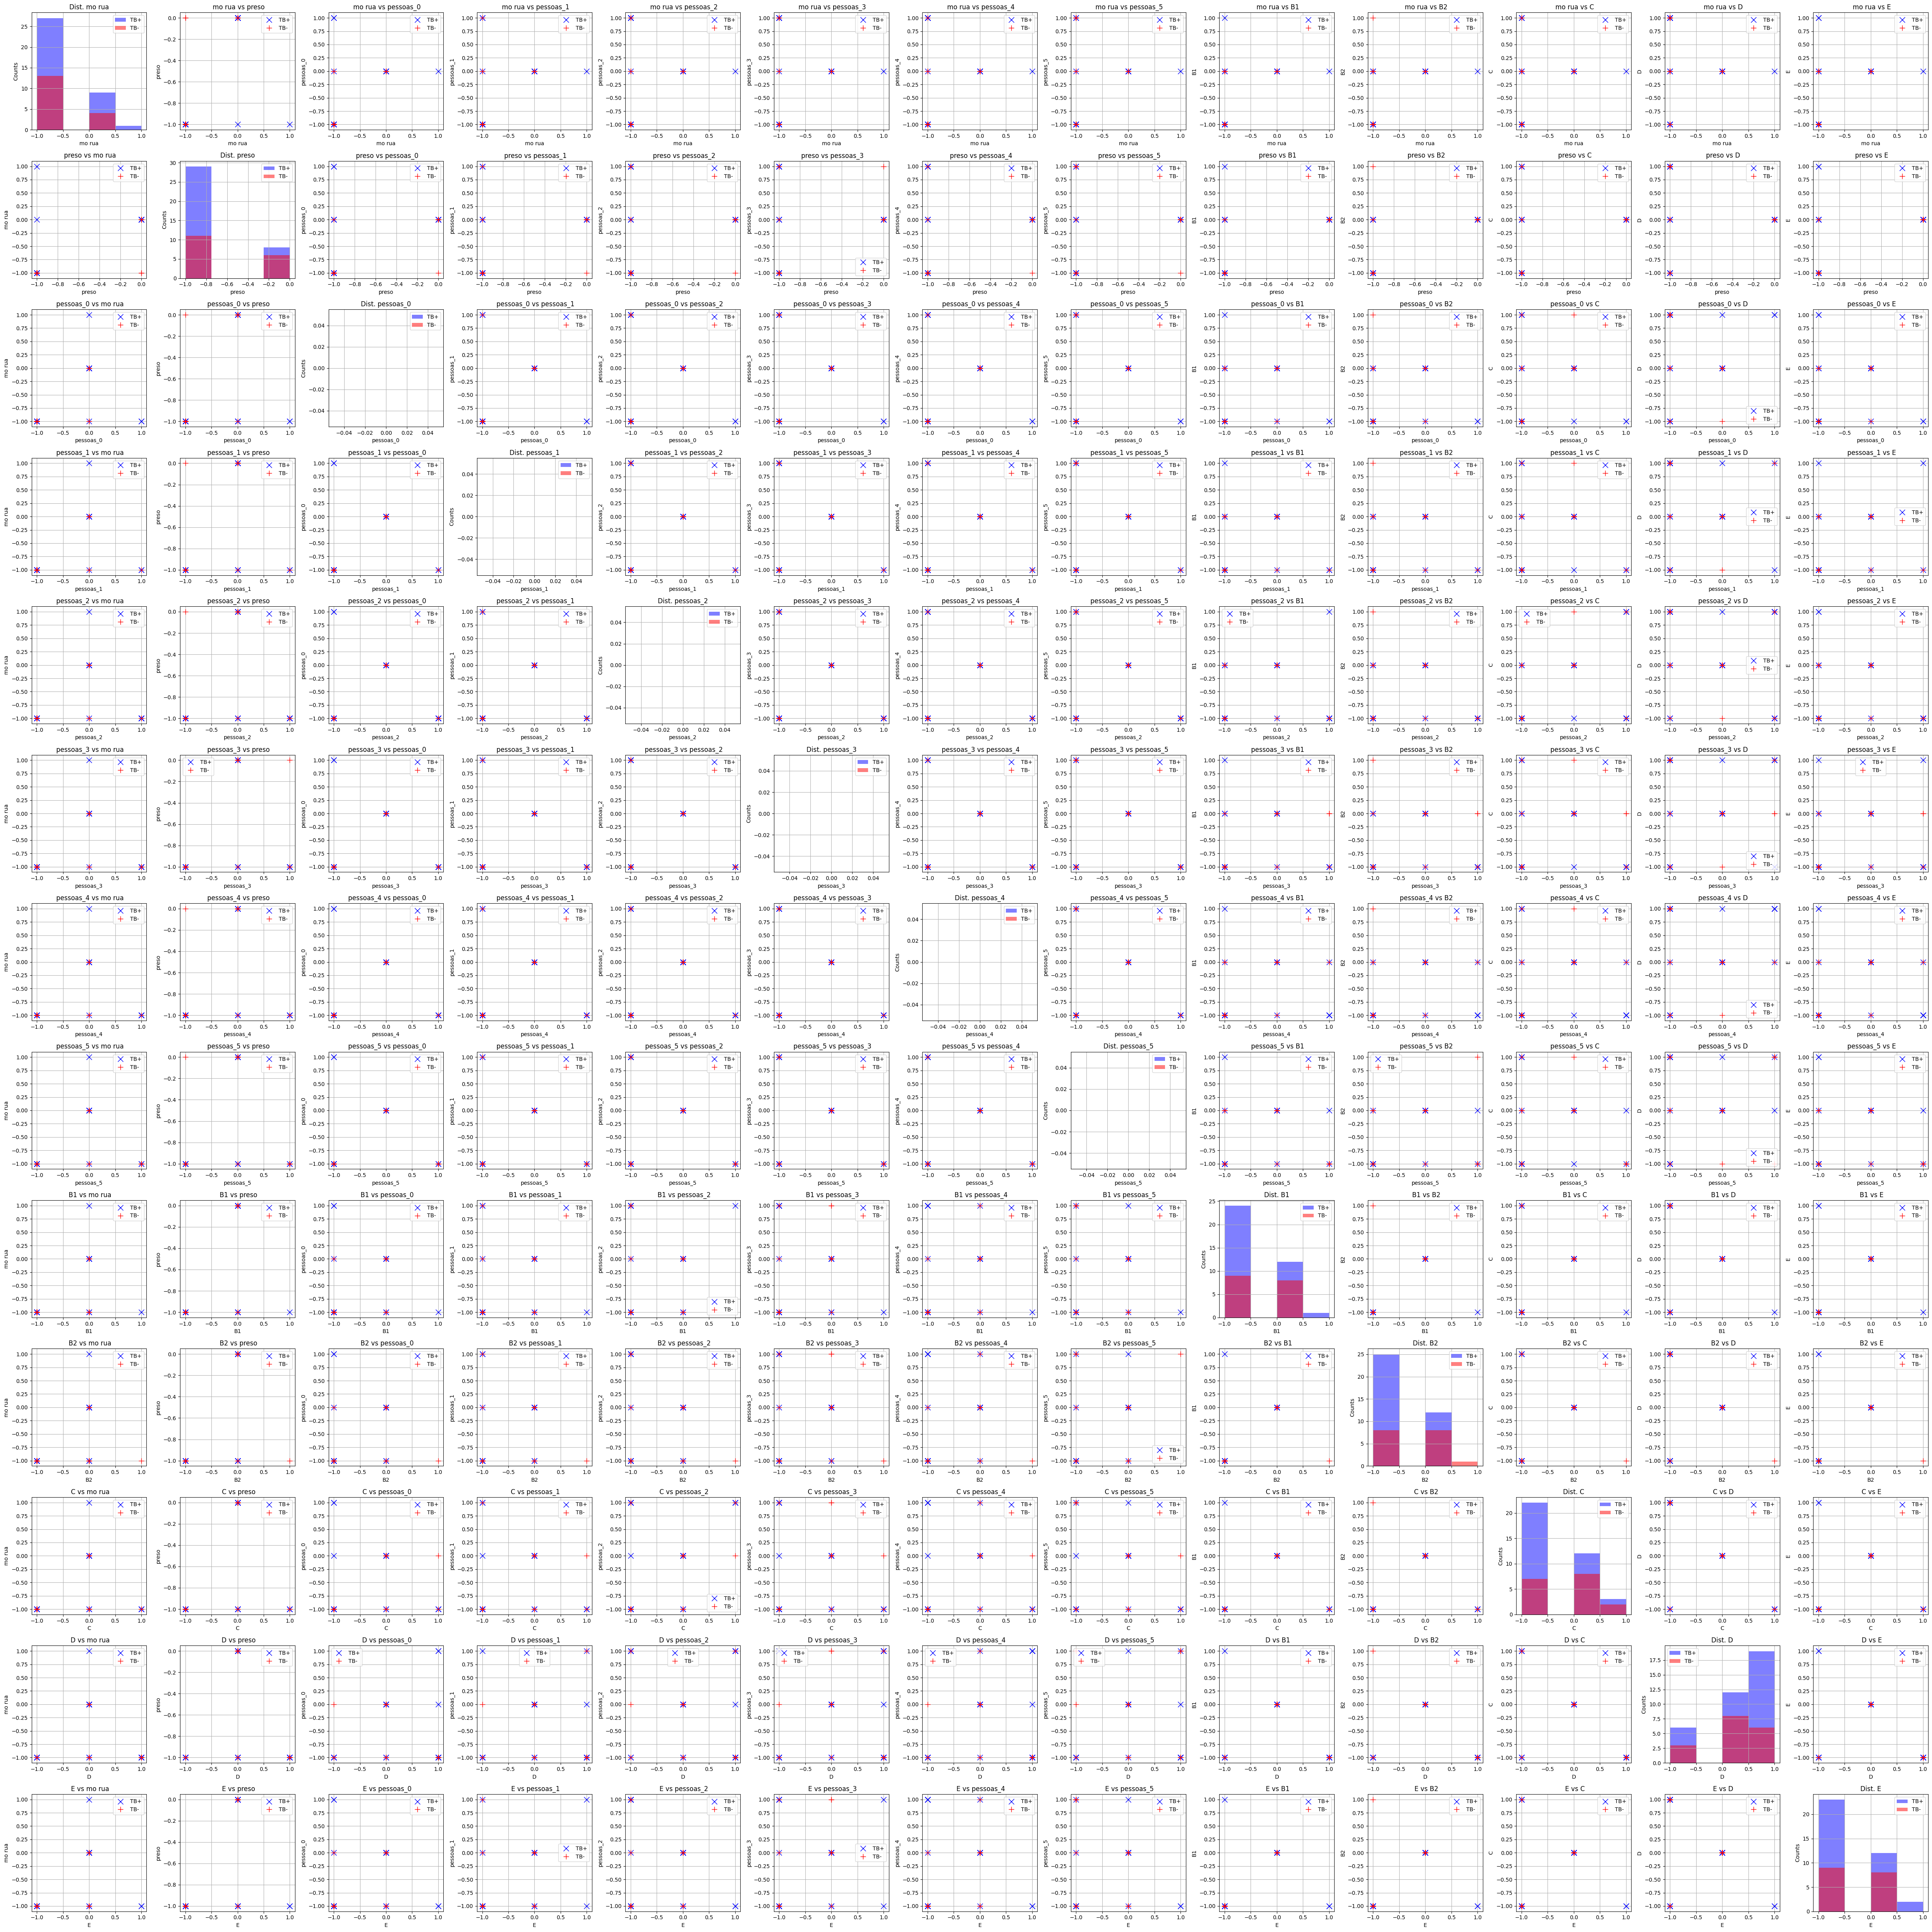

In [116]:
#anal_data = dev_social[['mo rua','preso']].copy(deep=True)
anal_data = dev_social
qtd_variables = len(anal_data.columns)

#fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(6, 6))
fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(50, 50))


for iid, ivar in enumerate(anal_data.columns):
    for jid, jvar in enumerate(anal_data.columns):
        #print ('ivar: %s, jvar: %s'%(ivar, jvar))
        if ivar == jvar:
            # print a distribution
            m_bins = np.linspace(np.min(anal_data[ivar].values),np.max(anal_data[ivar].values),5)
            #print('m_bins: ', m_bins)
            pos_values = anal_data[ivar].values
            pos_values = pos_values[:,np.newaxis]
            pos_values = pos_values[dev_target.values==1]
            
            neg_values = anal_data[ivar].values
            neg_values = neg_values[:,np.newaxis]
            neg_values = neg_values[dev_target.values==-1]
            
            ax[iid, jid].hist(pos_values, m_bins, facecolor='blue', alpha=0.5, label='TB+')
            ax[iid, jid].hist(neg_values, m_bins, facecolor='red', alpha=0.5, label='TB-')
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title('Dist. %s'%(ivar))
            ax[iid, jid].set_ylabel('Counts')
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
        else:
            # print a scatter plot
            pos_values_1 = anal_data[ivar].values
            pos_values_1 = pos_values_1[:,np.newaxis]
            pos_values_1 = pos_values_1[dev_target.values==1]
            
            neg_values_1 = anal_data[ivar].values
            neg_values_1 = neg_values_1[:,np.newaxis]
            neg_values_1 = neg_values_1[dev_target.values==-1]
            
            pos_values_2 = anal_data[jvar].values
            pos_values_2 = pos_values_2[:,np.newaxis]
            pos_values_2 = pos_values_2[dev_target.values==1]
            
            neg_values_2 = anal_data[jvar].values
            neg_values_2 = neg_values_2[:,np.newaxis]
            neg_values_2 = neg_values_2[dev_target.values==-1]
            
            ax[iid, jid].plot(pos_values_1, pos_values_2,'x', color='blue',label='TB+', markersize=10.)
            ax[iid, jid].plot(neg_values_1, neg_values_2,'+', color='red',label='TB-', markersize=10.)
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title(' %s vs %s'%(ivar,jvar))
            ax[iid, jid].set_ylabel(jvar)
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
plt.tight_layout()
fig.savefig('scatter_social.pdf',bbox_inches='tight')
fig.savefig('scatter_social.png',bbox_inches='tight', dpi=400)
plt.show()


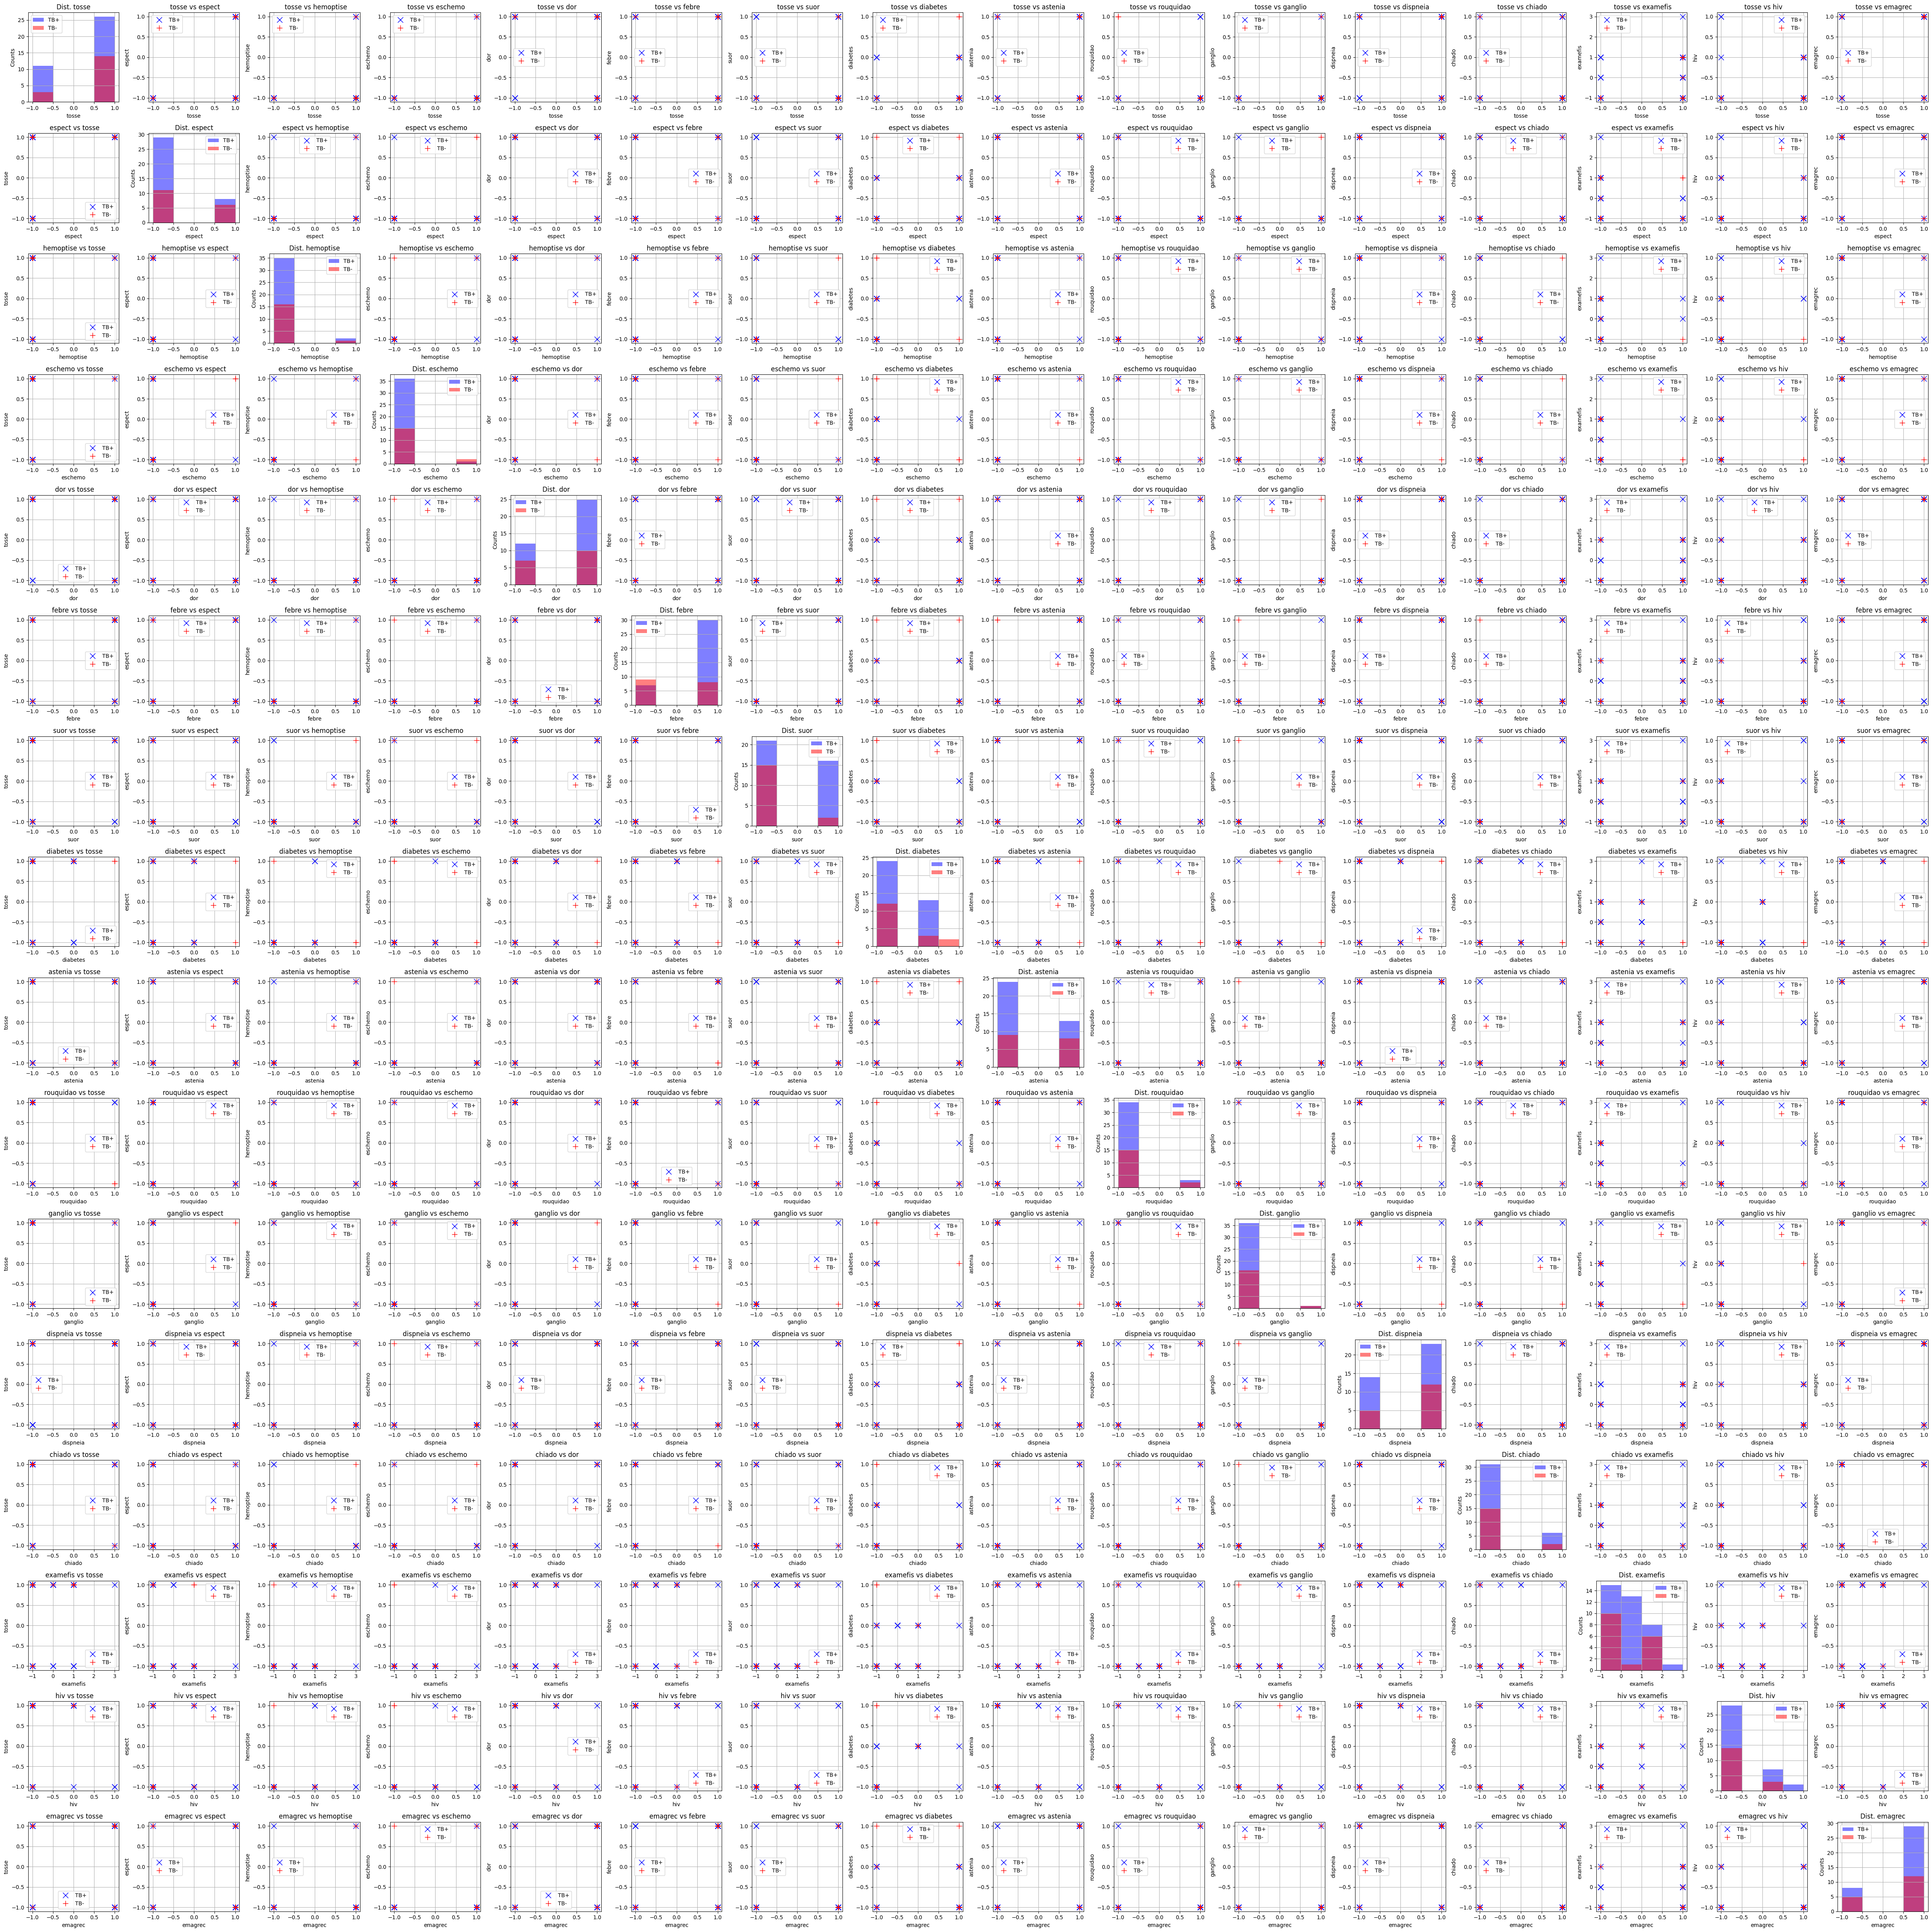

In [117]:
#anal_data = dev_social[['mo rua','preso']].copy(deep=True)
anal_data = dev_clinical
qtd_variables = len(anal_data.columns)

#fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(6, 6))
fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(50, 50))


for iid, ivar in enumerate(anal_data.columns):
    for jid, jvar in enumerate(anal_data.columns):
        #print ('ivar: %s, jvar: %s'%(ivar, jvar))
        if ivar == jvar:
            # print a distribution
            m_bins = np.linspace(np.min(anal_data[ivar].values),np.max(anal_data[ivar].values),5)
            #print('m_bins: ', m_bins)
            pos_values = anal_data[ivar].values
            pos_values = pos_values[:,np.newaxis]
            pos_values = pos_values[dev_target.values==1]
            
            neg_values = anal_data[ivar].values
            neg_values = neg_values[:,np.newaxis]
            neg_values = neg_values[dev_target.values==-1]
            
            ax[iid, jid].hist(pos_values, m_bins, facecolor='blue', alpha=0.5, label='TB+')
            ax[iid, jid].hist(neg_values, m_bins, facecolor='red', alpha=0.5, label='TB-')
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title('Dist. %s'%(ivar))
            ax[iid, jid].set_ylabel('Counts')
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
        else:
            # print a scatter plot
            pos_values_1 = anal_data[ivar].values
            pos_values_1 = pos_values_1[:,np.newaxis]
            pos_values_1 = pos_values_1[dev_target.values==1]
            
            neg_values_1 = anal_data[ivar].values
            neg_values_1 = neg_values_1[:,np.newaxis]
            neg_values_1 = neg_values_1[dev_target.values==-1]
            
            pos_values_2 = anal_data[jvar].values
            pos_values_2 = pos_values_2[:,np.newaxis]
            pos_values_2 = pos_values_2[dev_target.values==1]
            
            neg_values_2 = anal_data[jvar].values
            neg_values_2 = neg_values_2[:,np.newaxis]
            neg_values_2 = neg_values_2[dev_target.values==-1]
            
            ax[iid, jid].plot(pos_values_1, pos_values_2,'x', color='blue',label='TB+', markersize=10.)
            ax[iid, jid].plot(neg_values_1, neg_values_2,'+', color='red',label='TB-', markersize=10.)
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title(' %s vs %s'%(ivar,jvar))
            ax[iid, jid].set_ylabel(jvar)
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
plt.tight_layout()
fig.savefig('scatter_clinical.pdf',bbox_inches='tight')
fig.savefig('scatter_clinical.png',bbox_inches='tight', dpi=400)
plt.show()

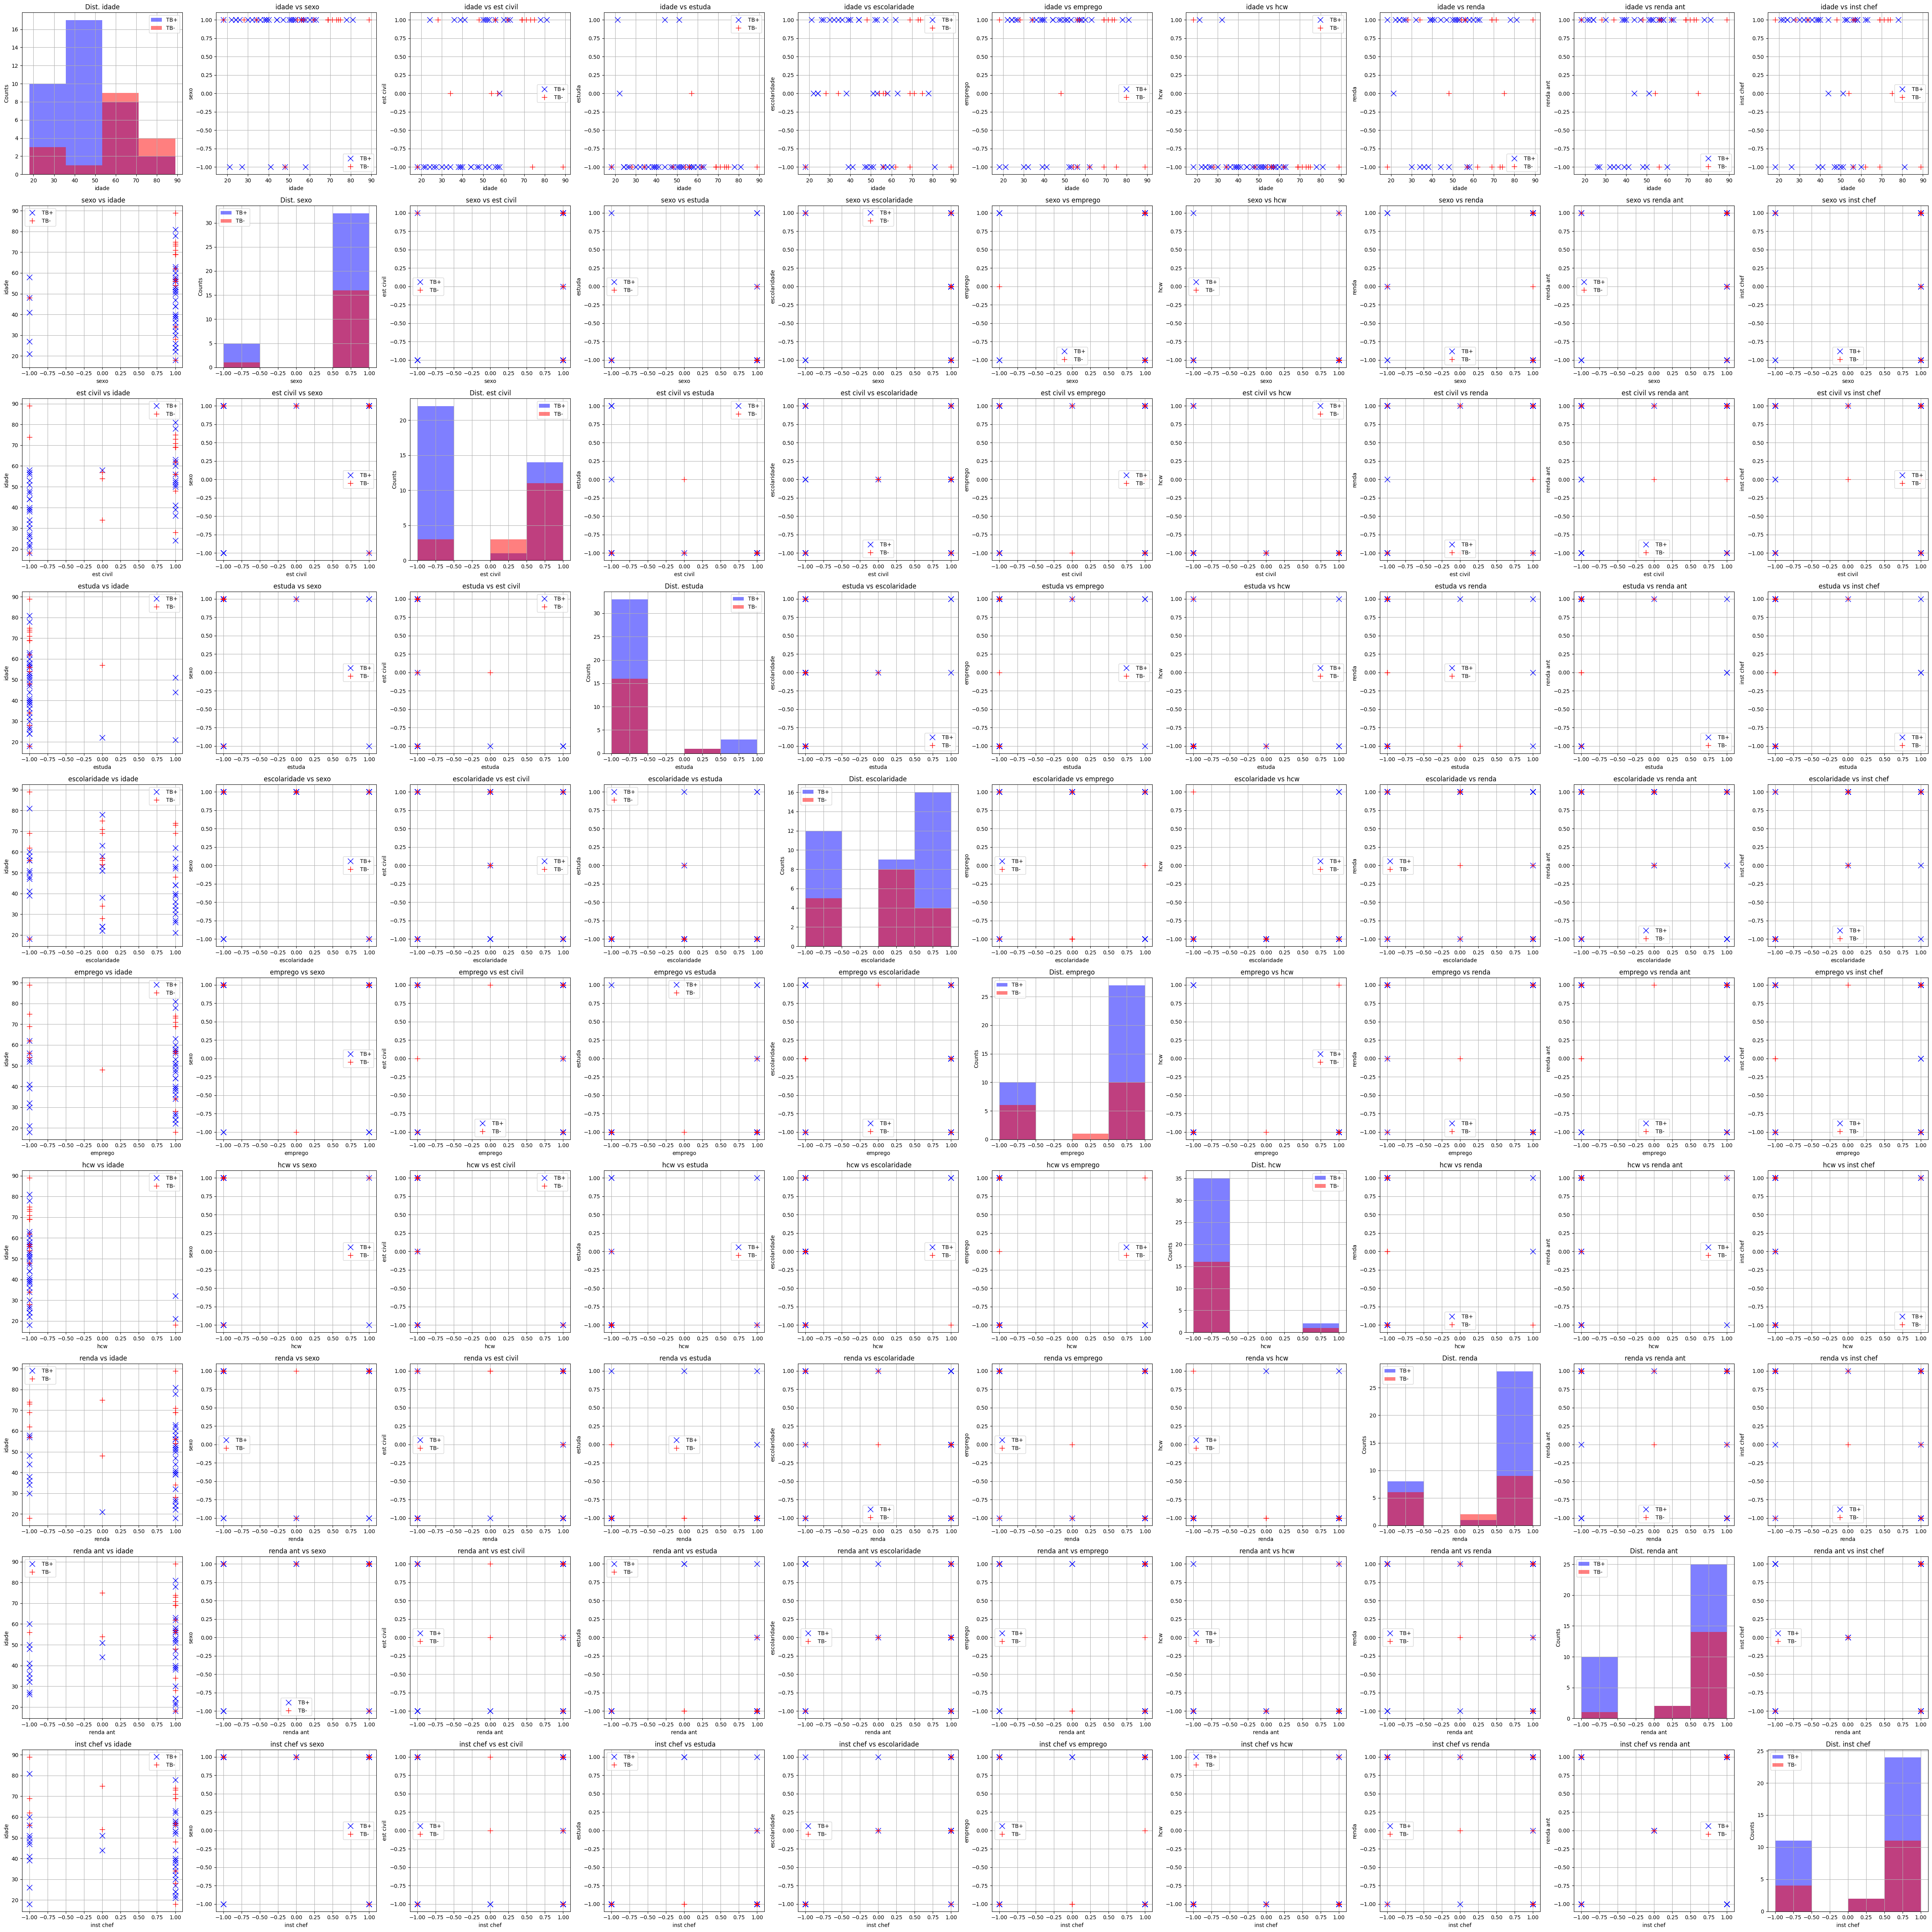

In [118]:
#anal_data = dev_social[['mo rua','preso']].copy(deep=True)
anal_data = dev_personal
qtd_variables = len(anal_data.columns)

#fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(6, 6))
fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(50, 50))


for iid, ivar in enumerate(anal_data.columns):
    for jid, jvar in enumerate(anal_data.columns):
        #print ('ivar: %s, jvar: %s'%(ivar, jvar))
        if ivar == jvar:
            # print a distribution
            m_bins = np.linspace(np.min(anal_data[ivar].values),np.max(anal_data[ivar].values),5)
            #print('m_bins: ', m_bins)
            pos_values = anal_data[ivar].values
            pos_values = pos_values[:,np.newaxis]
            pos_values = pos_values[dev_target.values==1]
            
            neg_values = anal_data[ivar].values
            neg_values = neg_values[:,np.newaxis]
            neg_values = neg_values[dev_target.values==-1]
            
            ax[iid, jid].hist(pos_values, m_bins, facecolor='blue', alpha=0.5, label='TB+')
            ax[iid, jid].hist(neg_values, m_bins, facecolor='red', alpha=0.5, label='TB-')
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title('Dist. %s'%(ivar))
            ax[iid, jid].set_ylabel('Counts')
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
        else:
            # print a scatter plot
            pos_values_1 = anal_data[ivar].values
            pos_values_1 = pos_values_1[:,np.newaxis]
            pos_values_1 = pos_values_1[dev_target.values==1]
            
            neg_values_1 = anal_data[ivar].values
            neg_values_1 = neg_values_1[:,np.newaxis]
            neg_values_1 = neg_values_1[dev_target.values==-1]
            
            pos_values_2 = anal_data[jvar].values
            pos_values_2 = pos_values_2[:,np.newaxis]
            pos_values_2 = pos_values_2[dev_target.values==1]
            
            neg_values_2 = anal_data[jvar].values
            neg_values_2 = neg_values_2[:,np.newaxis]
            neg_values_2 = neg_values_2[dev_target.values==-1]
            
            ax[iid, jid].plot(pos_values_1, pos_values_2,'x', color='blue',label='TB+', markersize=10.)
            ax[iid, jid].plot(neg_values_1, neg_values_2,'+', color='red',label='TB-', markersize=10.)
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title(' %s vs %s'%(ivar,jvar))
            ax[iid, jid].set_ylabel(jvar)
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
plt.tight_layout()
fig.savefig('scatter_personal.pdf',bbox_inches='tight')
fig.savefig('scatter_personal.png',bbox_inches='tight', dpi=400)
plt.show()

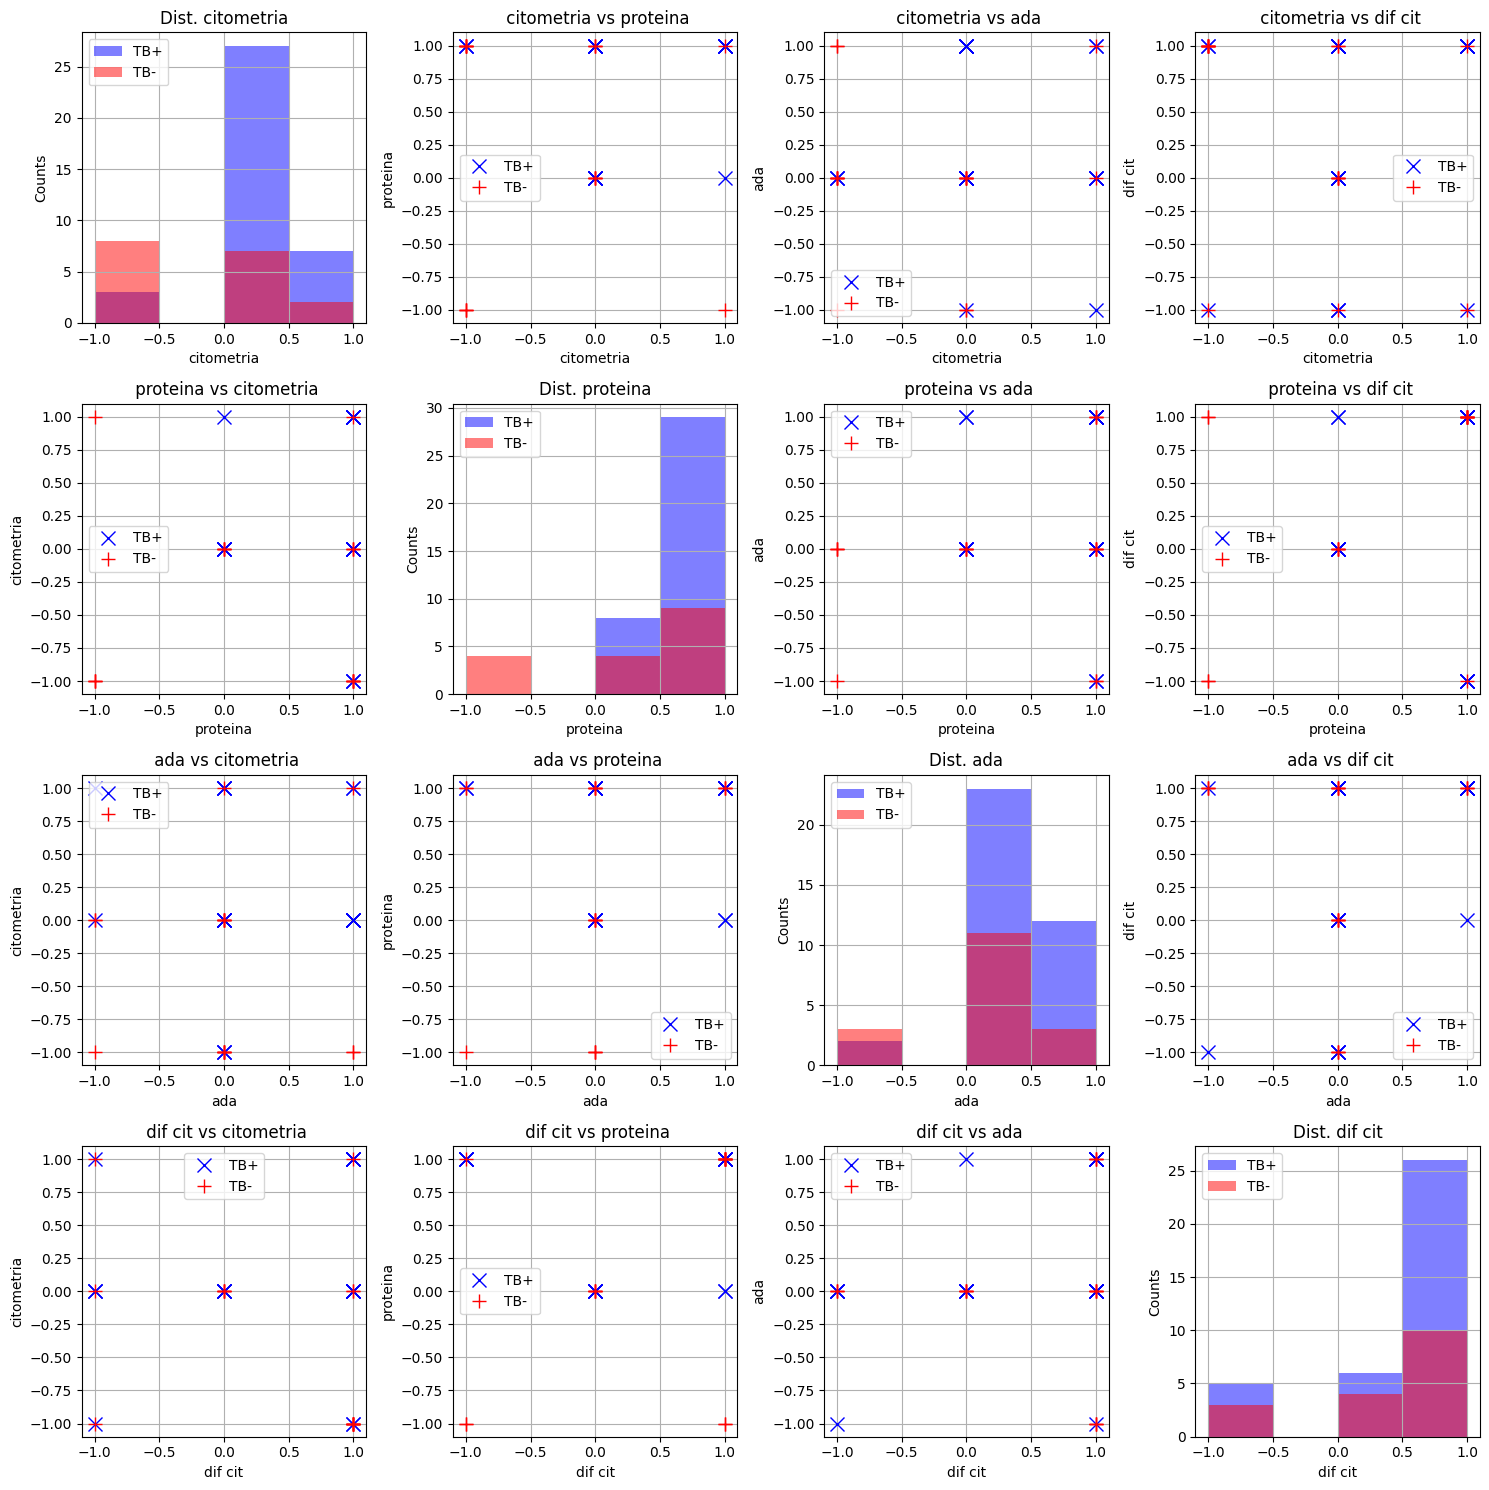

In [122]:
#anal_data = dev_social[['mo rua','preso']].copy(deep=True)
anal_data = dev_pos_test
qtd_variables = len(anal_data.columns)

#fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(6, 6))
fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(15, 15))


for iid, ivar in enumerate(anal_data.columns):
    for jid, jvar in enumerate(anal_data.columns):
        #print ('ivar: %s, jvar: %s'%(ivar, jvar))
        if ivar == jvar:
            # print a distribution
            m_bins = np.linspace(np.min(anal_data[ivar].values),np.max(anal_data[ivar].values),5)
            #print('m_bins: ', m_bins)
            pos_values = anal_data[ivar].values
            pos_values = pos_values[:,np.newaxis]
            pos_values = pos_values[dev_target.values==1]
            
            neg_values = anal_data[ivar].values
            neg_values = neg_values[:,np.newaxis]
            neg_values = neg_values[dev_target.values==-1]
            
            ax[iid, jid].hist(pos_values, m_bins, facecolor='blue', alpha=0.5, label='TB+')
            ax[iid, jid].hist(neg_values, m_bins, facecolor='red', alpha=0.5, label='TB-')
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title('Dist. %s'%(ivar))
            ax[iid, jid].set_ylabel('Counts')
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
        else:
            # print a scatter plot
            pos_values_1 = anal_data[ivar].values
            pos_values_1 = pos_values_1[:,np.newaxis]
            pos_values_1 = pos_values_1[dev_target.values==1]
            
            neg_values_1 = anal_data[ivar].values
            neg_values_1 = neg_values_1[:,np.newaxis]
            neg_values_1 = neg_values_1[dev_target.values==-1]
            
            pos_values_2 = anal_data[jvar].values
            pos_values_2 = pos_values_2[:,np.newaxis]
            pos_values_2 = pos_values_2[dev_target.values==1]
            
            neg_values_2 = anal_data[jvar].values
            neg_values_2 = neg_values_2[:,np.newaxis]
            neg_values_2 = neg_values_2[dev_target.values==-1]
            
            ax[iid, jid].plot(pos_values_1, pos_values_2,'x', color='blue',label='TB+', markersize=10.)
            ax[iid, jid].plot(neg_values_1, neg_values_2,'+', color='red',label='TB-', markersize=10.)
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title(' %s vs %s'%(ivar,jvar))
            ax[iid, jid].set_ylabel(jvar)
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
plt.tight_layout()
fig.savefig('scatter_pos_test.pdf',bbox_inches='tight')
fig.savefig('scatter_pos_test.png',bbox_inches='tight', dpi=400)
plt.show()